In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

Load data

PFMs


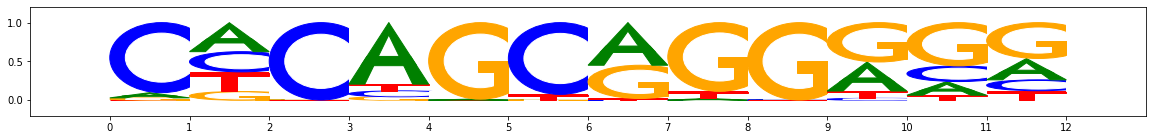

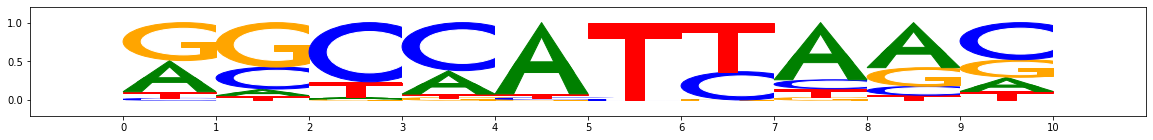

In [436]:
import modisco.util
reload(modisco.util)

def convert_motif_string(motif_string):
    to_return = np.array([[float(x) for x in row.lstrip().rstrip().split("  ")]
                       for row in motif_string.split("\n")])
    viz_sequence.plot_weights(to_return)
    return to_return

print("PFMs")
zic3 = convert_motif_string(
"""0.067  0.902  0.030  0.001
0.373  0.260  0.113  0.253
0.001  0.997  0.001  0.001
0.792  0.076  0.045  0.087
0.012  0.001  0.986  0.001
0.001  0.924  0.001  0.074
0.549  0.001  0.428  0.022
0.022  0.001  0.885  0.092
0.001  0.001  0.997  0.001
0.374  0.025  0.507  0.094
0.176  0.202  0.557  0.065
0.275  0.140  0.462  0.123""")

nanog = convert_motif_string("""0.401  0.024  0.489  0.086
0.085  0.283  0.572  0.06
0.026  0.762  0.016  0.196
0.301698301698302  0.618381618381618  0.034965034965035  0.0449550449550449
0.918081918081918  0.018981018981019  0.010989010989011  0.0519480519480519
0.001  0.003  0.001  0.995
0.001  0.364  0.003  0.632
0.736  0.116  0.036  0.112
0.58  0.115  0.24  0.065
0.182  0.477  0.227  0.114""")

sox2 = convert_motif_string("""0.339401  0.128752  0.249948  0.281899
 0.353091  0.176715  0.200072  0.270122
 0.973890  0.005084  0.004874  0.016151
 0.015241  0.913730  0.014495  0.056534
 0.951408  0.014052  0.006414  0.028127
 0.942522  0.020314  0.023346  0.013819
 0.056149  0.008536  0.010845  0.924470
 0.115750  0.009329  0.855610  0.019311
 0.172260  0.073046  0.634536  0.120158
 0.336544  0.200084  0.207162  0.256210
 0.337710  0.203781  0.186557  0.271952""")


octsox = convert_motif_string("""0.046188  0.620235  0.048387  0.285191
 0.423865  0.042460  0.020498  0.513177
 0.008047  0.036576  0.026335  0.929042
 0.034332  0.008766  0.057706  0.899196
 0.086194  0.265157  0.602630  0.046019
 0.303141  0.013148  0.021183  0.662527
 0.150475  0.266618  0.135866  0.447042
 0.902118  0.021914  0.017531  0.058437
 0.012418  0.003652  0.010957  0.972973
 0.007305  0.011687  0.905040  0.075968
 0.010234  0.752193  0.094298  0.143275
 0.769231  0.011722  0.021978  0.197070
 0.651248  0.049927  0.231278  0.067548
 0.881705  0.024247  0.055107  0.038942
 0.145481  0.087436  0.152094  0.614989""")


pwms = [modisco.util.get_logodds_pwm(ppm=x, background=np.array([0.27, 0.23, 0.23, 0.27]), pseudocount=1e-5)
        for x in [zic3, nanog, sox2, octsox]]

In [423]:
import numpy as np

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
#read in the fasta files and one-hot encode
fasta_seqs = [x.rstrip() for (i,x) in enumerate(open("positives_test.fa"))
              if i%2==1]
#filter out any sequences that contain 'N's
onehot_data = [np.array(one_hot_encode_along_channel_axis(x))
                         for x in fasta_seqs if ('N' not in x)]
print("Num onehot sequences:",len(onehot_data))

#read in the importance scores and hypothetical importance scores
#filter out any sequences that contain 'N's
hyp_impscores = [w[0] for w in zip([
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("gkmexplain_positives_hypimpscores.txt")
],fasta_seqs) if 'N' not in w[1]]

impscores = [w[0] for w in zip([
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("gkmexplain_positives_impscores.txt")
],fasta_seqs) if 'N' not in w[1]]

#Perform a sanity check to make sure that the importance score are the same as the
# hypothetical scores multiplied elementwise with the one-hot encoding; for this
# reason, it is not technically necessary to compute the importance scores if the
# hypothetical scores are also computed
assert (np.max([np.max(np.abs(z*y - x)) for x,y,z in zip(impscores,onehot_data,hyp_impscores)]))==0

#Read in scores on the dinucleotide-shuffled sequences, taking
# the sum across ACGT at each position, to get an empirical null distribution
# of per-position importance scores
nulldist_perposimp = [
    np.array( [sum([float(z) for z in y.split(",")]) for
                y in x.rstrip().split("\t")[2].split(";")])
    for x in open("gkmexplain_dnshuff_impscores.txt")]

Num onehot sequences: 960


In [448]:
#loading the coords
import modisco.core
reload(modisco.core)

meannormhyp = hyp_impscores-np.mean(hyp_impscores,axis=-1)[:,:,None]
impfrommeannormhyp = meannormhyp*onehot_data

meannormcontrib_scores_track = modisco.core.DataTrack(name="meannormcontrib_scores",
                                                      fwd_tracks=impfrommeannormhyp,
                                                      rev_tracks=[x[::-1, ::-1] for x in impfrommeannormhyp])
contrib_scores_track = modisco.core.DataTrack(name="contrib_scores",
                                              fwd_tracks=impscores,
                                              rev_tracks=[x[::-1, ::-1] for x in impscores])
meannormhypcontrib_scores_track = modisco.core.DataTrack(name="meannormhypcontrib_scores",
                                                         fwd_tracks=meannormhyp,
                                                         rev_tracks=[x[::-1, ::-1] for x in meannormhyp])
hypcontrib_scores_track = modisco.core.DataTrack(name="hypcontrib_scores",
                                                 fwd_tracks=hyp_impscores,
                                                 rev_tracks=[x[::-1, ::-1] for x in hyp_impscores])
onehot_track = modisco.core.DataTrack(name="onehot",
                         fwd_tracks=onehot_data,
                         rev_tracks=[x[::-1, ::-1] for x in onehot_data])
track_set = modisco.core.DataTrackSet(data_tracks=[
                contrib_scores_track, hypcontrib_scores_track,
                meannormcontrib_scores_track, meannormhypcontrib_scores_track, onehot_track])

coords = []
for i,line in enumerate(open("seqlets.fa")):
    if (i%2==0):
        beforecolon, aftercolon = line.rstrip().split(":")
        example_idx = int(beforecolon[3:])
        start, end = aftercolon.split("-")
        start, end = int(start), int(end)
        coords.append(modisco.core.Coordinate(
                        example_idx=example_idx, start=start+10,
                        end=end-10, is_revcomp=False))
    
seqlets = track_set.create_seqlets(coords=coords, flanks=10)


In [453]:
import modisco.util
reload(modisco.util)
from collections import Counter

#scan for motif hits
onehot_seqs = np.array([x["onehot"].corefwd for x in seqlets])
scores = np.array([np.max(np.maximum(modisco.util.compute_pwm_scan(onehot_seq=onehot_seqs,
                                                                   weightmat=pwm),
                                     modisco.util.compute_pwm_scan(onehot_seq=onehot_seqs,
                                                                   weightmat=pwm[::-1,::-1])), axis=1)
                  for pwm in pwms])
pwm_hits = (scores*(scores==np.max(scores,0)[None,:])) > 2
cluster_membership = (np.argmax(pwm_hits,axis=0)+1)*np.sum(pwm_hits,axis=0)
num_unassigned = np.sum(np.sum(pwm_hits,axis=0)==0)
print(np.sum(pwm_hits, axis=-1))
cluster_limits = [0,num_unassigned]+list(np.cumsum(np.sum(pwm_hits, axis=-1))+num_unassigned)
print(cluster_limits)

#get the seqlet reordering
clusterordering = np.argsort(cluster_membership)

[169 254 170 173]
[0, 170, 339, 593, 763, 936]


In [454]:
import modisco.affinitymat
reload(modisco.affinitymat)
import modisco.util
reload(modisco.util)
import gc
gc.collect()

affmat_computer = modisco.affinitymat.SequenceAffmatComputer_Impute(
                    metric=modisco.util.l1norm_contin_jaccard_sim,
                    n_jobs=4, min_overlap_frac=0.6)

affmat, offsets, isfwdmat = affmat_computer(seqlets[:], onehot_trackname="onehot",
                                            hyp_trackname="meannormhypcontrib_scores")

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   22.5s
[Parallel(n_jobs=4)]: Done 936 out of 936 | elapsed:   24.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   12.1s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   30.4s
[Parallel(n_jobs=4)]: Done 936 out of 936 | elapsed:   32.6s finished


In [456]:
import seaborn as sns

sns.heatmap(affmat[clusterordering][:,clusterordering]*(affmat[clusterordering][:,clusterordering]<1.0))
plt.show()

In [595]:
affmat_percentiles = modisco.util.percentile_transform(vals=affmat.ravel()).reshape((len(affmat), len(affmat)))
sns.heatmap(affmat_percentiles[clusterordering][:,clusterordering])
plt.show()


In [613]:
distmat_percentiles = 1/np.maximum(affmat_percentiles, 1e-7) - 1
sns.heatmap(distmat_percentiles[clusterordering][:,clusterordering])
plt.show()

[t-SNE] Computing 935 nearest neighbors...
[t-SNE] Indexed 936 samples in 0.001s...
[t-SNE] Computed neighbors for 936 samples in 0.062s...
[t-SNE] Computed conditional probabilities for sample 936 / 936
[t-SNE] Mean sigma: 0.085976
num_neighbors


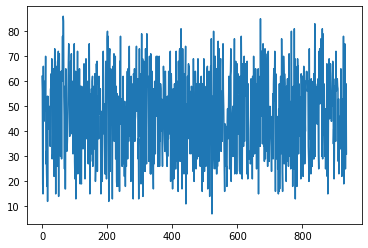

Median number of neighbors - tsne 49.0


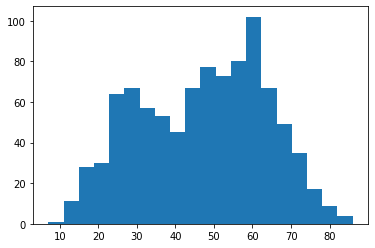

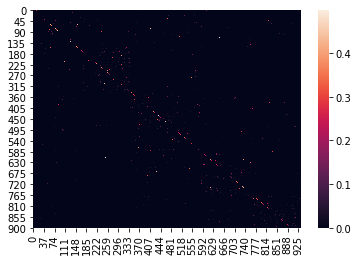

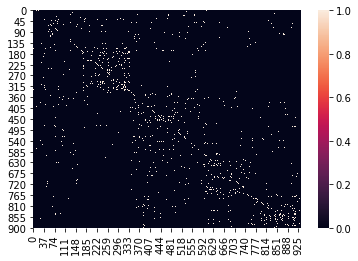

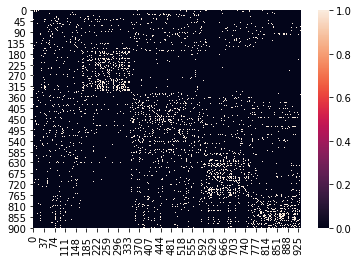

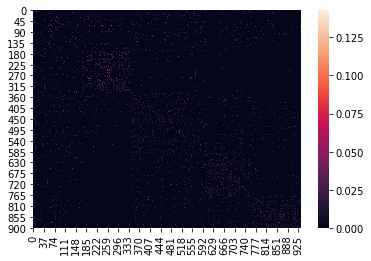

In [615]:
reload(modisco.core)
reload(modisco.affinitymat)
reload(modisco.util)
from matplotlib import pyplot as plt
import scipy

n_neighbors = 30
#flatten = 1
#distmat = np.log(1.0/(flatten*np.maximum(affmat,1e-7) ) - (1.0/flatten - 1))
#distmat = 1.0/(np.maximum(affmat,1e-7)) - 1.0
#sns.heatmap(distmat[clusterordering][:,clusterordering])
#plt.show()

tsne_adapted = modisco.affinitymat.tsne_density_adaptation(dist_mat=distmat_percentiles,
                                                           perplexity=n_neighbors,
                                                          )#max_neighbors=n_neighbors*1)
tsne_adapted = tsne_adapted + np.eye(len(tsne_adapted))*np.max(tsne_adapted,axis=1)
tsne_adapted = tsne_adapted/np.sum(tsne_adapted, axis=-1)[:,None]
print("num_neighbors")
plt.plot(np.arange(len(tsne_adapted)),np.sum(tsne_adapted>0, axis=1))
plt.show()
print("Median number of neighbors - tsne",np.median(np.sum(tsne_adapted>0, axis=1)))
plt.hist(np.sum(tsne_adapted>0, axis=1), bins=20)
plt.show()

#print(np.diag(tsne_adapted))
sns.heatmap(tsne_adapted[clusterordering][:,clusterordering])
plt.show()
sns.heatmap((tsne_adapted>(0.1/n_neighbors))[clusterordering][:,clusterordering])
plt.show()

sns.heatmap((tsne_adapted>0)[clusterordering][:,clusterordering])
plt.show()

sns.heatmap(((tsne_adapted>0)/np.sum((tsne_adapted>0), axis=-1)[:,None])[clusterordering][:,clusterordering])
plt.show()

#plt.hist(tsne_adapted.ravel()[tsne_adapted.ravel() > 0.001], bins=20)
#plt.show()

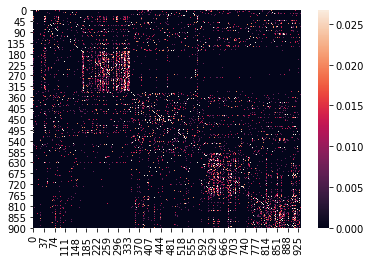

[10]


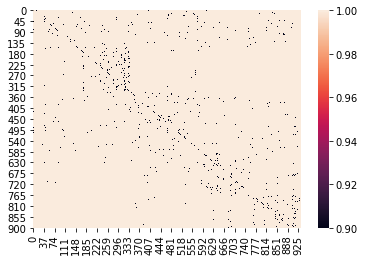

[10, 20]


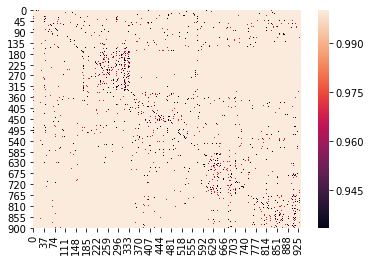

[10, 20, 40]


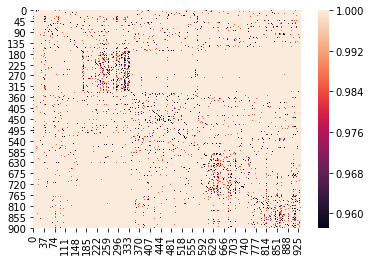

[10, 20, 40, 80]


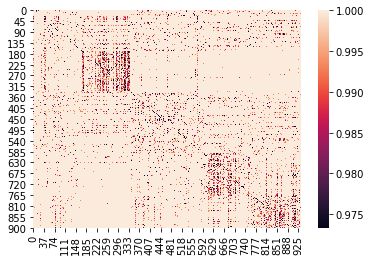

[10, 20, 40, 80, 160]


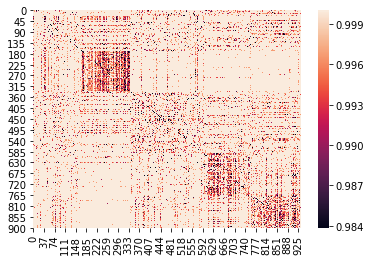

[10, 20, 40, 80, 160, 320]


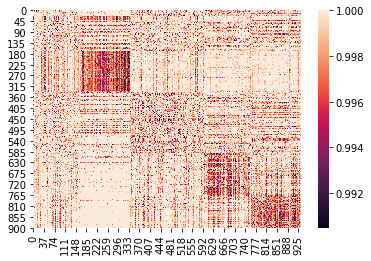

In [653]:
#create an affmat where each thing is closest to only the top 30 nearest neighbors
def nearest_neighb_affmat(affmat, n_neighbs):
    #argsort each row, take n_neighb, set prob accordingly
    argsortrows = np.argsort(affmat,axis=-1)
    new_affmat = np.zeros_like(affmat)
    for idx,row in enumerate(argsortrows):
        for n_neighb in n_neighbs:
            nearest_neighbs = row[::-1][:n_neighb]
            new_affmat[idx,nearest_neighbs] += 1.0
    new_affmat = new_affmat/np.sum(new_affmat, axis=-1)[:,None]
    return new_affmat

nneighb_affmat = nearest_neighb_affmat(affmat=affmat, n_neighbs=[10,20,40,80])
sns.heatmap(nneighb_affmat[clusterordering][:,clusterordering])
plt.show()

for i in range(6):
    n_neighbs = [10*(2**(j)) for j in range(i+1)]
    print(n_neighbs)
    sns.heatmap(1-nearest_neighb_affmat(affmat=affmat, n_neighbs=n_neighbs)[clusterordering][:,clusterordering])
    plt.show()


1


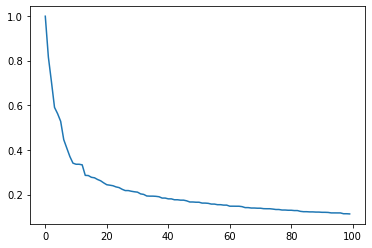

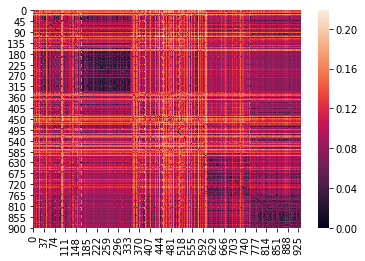

2


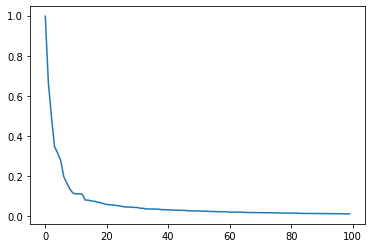

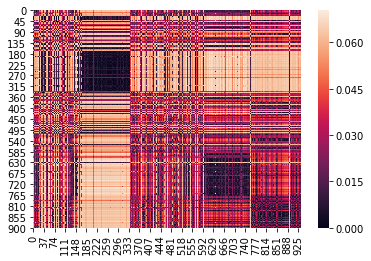

In [654]:
def get_diffusion_distances(affmat,t,k=100):
    assert np.abs(np.max(np.sum(affmat, axis=-1))-1.0) < 1e-7, np.max(np.sum(affmat, axis=-1))
    assert np.abs(np.min(np.sum(affmat, axis=-1))-1.0) < 1e-7, np.min(np.sum(affmat, axis=-1))
    affmat = np.linalg.matrix_power(affmat,t)
    evals, evecs = np.linalg.eig(affmat)
    #based on https://github.com/DiffusionMapsAcademics/pyDiffMap/blob/d36e632089d564a4fc169d29f81c4783ddd39fd3/src/pydiffmap/diffusion_map.py#L154
    #discard the "all equal" eigenvector
    ix = np.argsort(evals)[::-1][1:1+k]
    evals = evals[ix]
    evecs = evecs[:,ix]
    plt.plot(np.arange(len(evals)), evals)
    plt.show()
    dmap = np.dot(evecs, np.diag(np.power(evals,t)))
    dists = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(dmap, metric='euclidean'))
    return dists

for t in range(1,3):
    print(t)
    nneighb_diffdist = get_diffusion_distances(affmat=nneighb_affmat,t=t)
    sns.heatmap(nneighb_diffdist[clusterordering][:,clusterordering])
    plt.show()
#    tsne_diffdist = get_diffusion_distances(affmat=(tsne_adapted)/(np.sum(tsne_adapted, axis=-1)[:,None]),t=t)
#    sns.heatmap(tsne_diffdist[clusterordering][:,clusterordering])
#    plt.show()
#    tsne_diffdist = get_diffusion_distances(affmat=(tsne_adapted>0)/(np.sum(tsne_adapted>0, axis=-1)[:,None]),t=t)
#    sns.heatmap(tsne_diffdist[clusterordering][:,clusterordering])
#    plt.show()

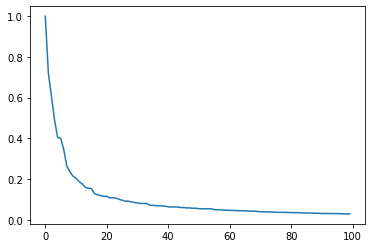

Quality: 0.006208486364536244
Quality: 0.006214499675145317
Quality: 0.006220096043228056
Quality: 0.006220145931258182
Quality: 0.006220295194760463
Quality: 0.006220503289917417

Counter({0: 302, 1: 294, 2: 238, 3: 102})
Numbed of clusters: 4
Cluster idx 0 size 302


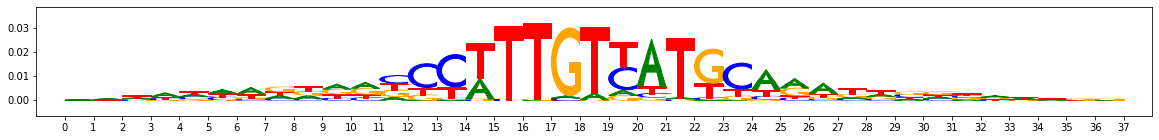

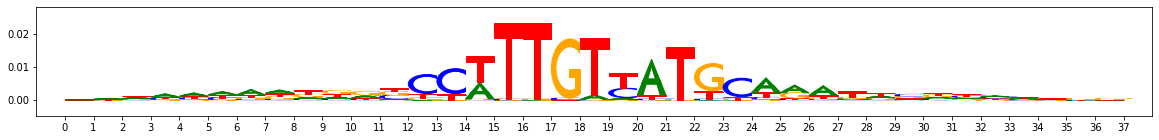

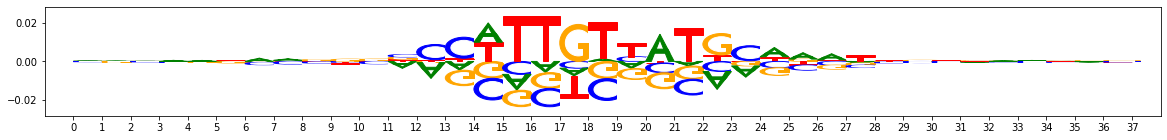

onehot


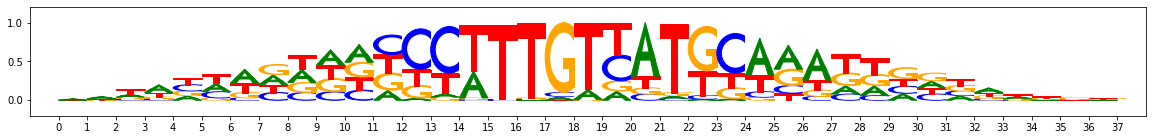

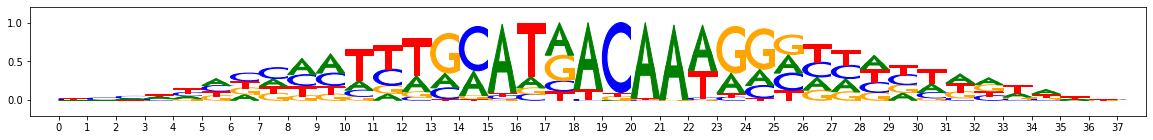

within v outside cluster jaccard sims


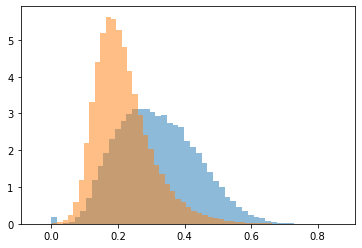

median within v outside cluster jaccard sims


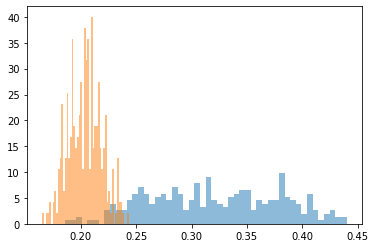

diff of median within v outside cluster jaccard sims


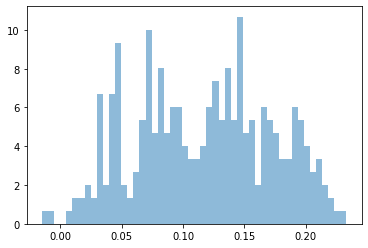

max within v outside cluster jaccard sims


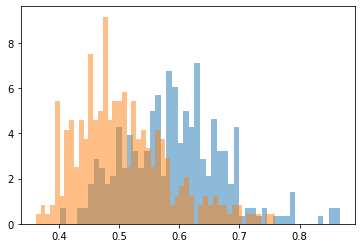

diff of max within v outside cluster jaccard sims


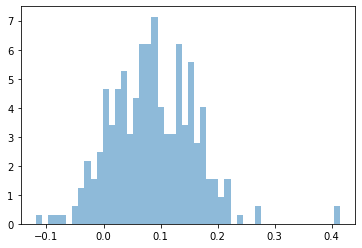

Cluster idx 1 size 294


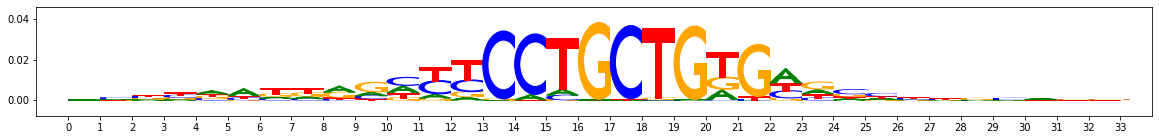

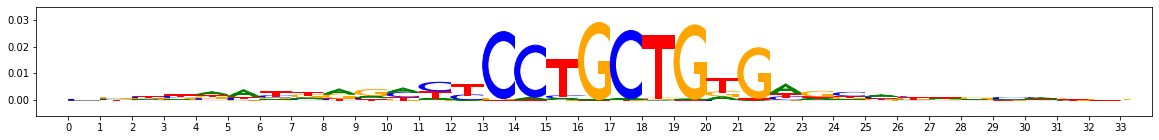

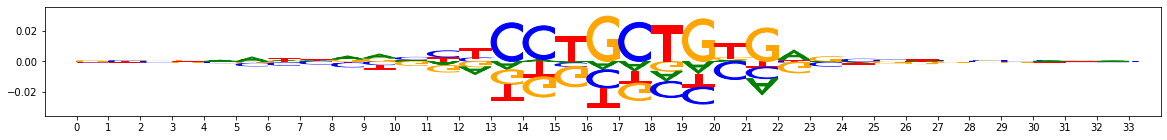

onehot


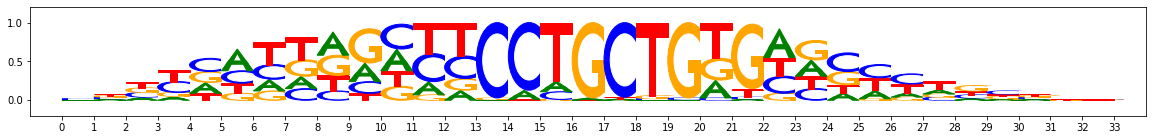

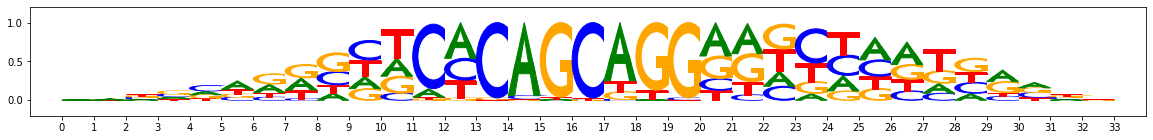

within v outside cluster jaccard sims


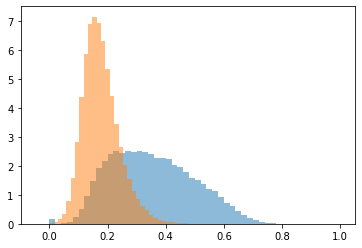

median within v outside cluster jaccard sims


diff of median within v outside cluster jaccard sims


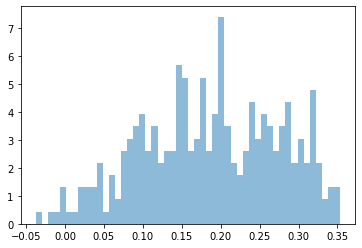

max within v outside cluster jaccard sims


diff of max within v outside cluster jaccard sims


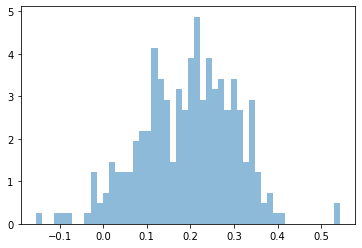

Cluster idx 2 size 238


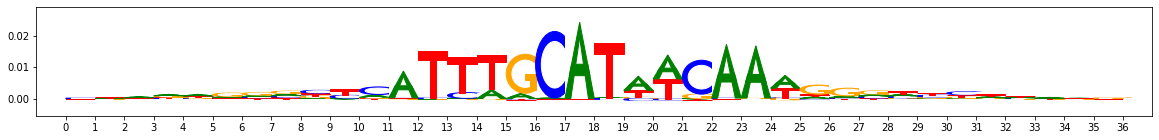

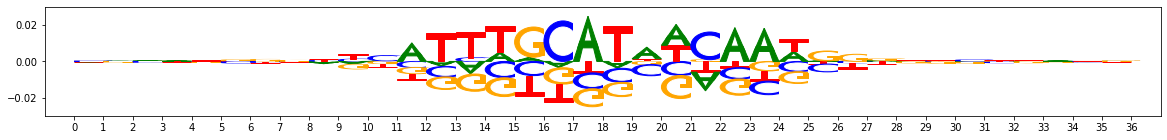

onehot


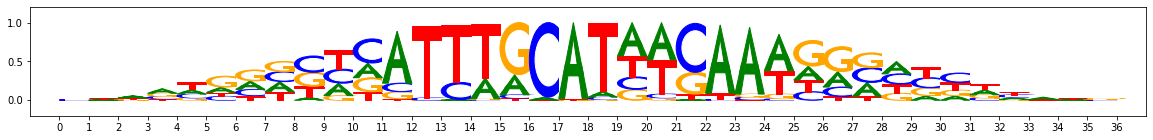

within v outside cluster jaccard sims


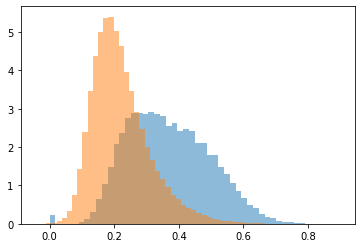

median within v outside cluster jaccard sims


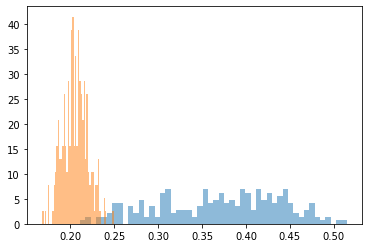

diff of median within v outside cluster jaccard sims


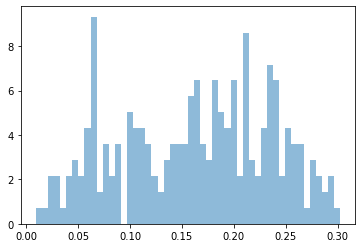

max within v outside cluster jaccard sims


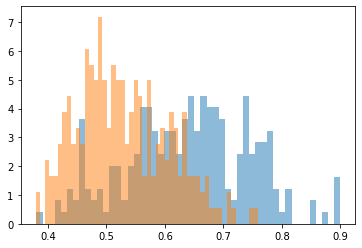

diff of max within v outside cluster jaccard sims


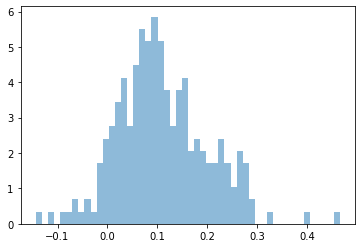

Cluster idx 3 size 102


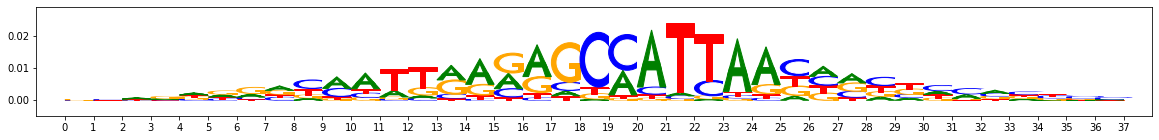

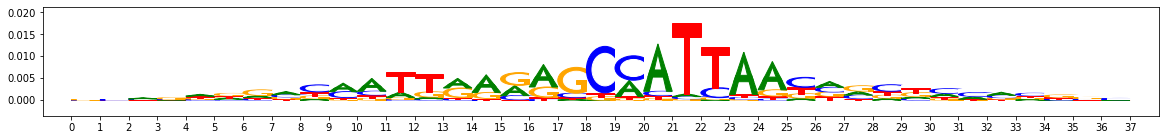

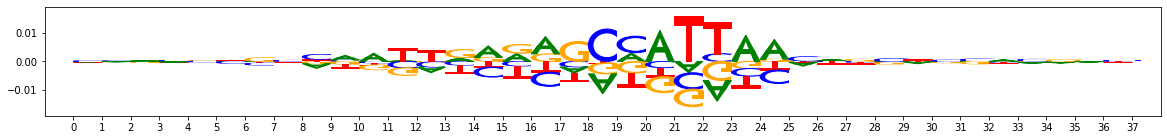

onehot


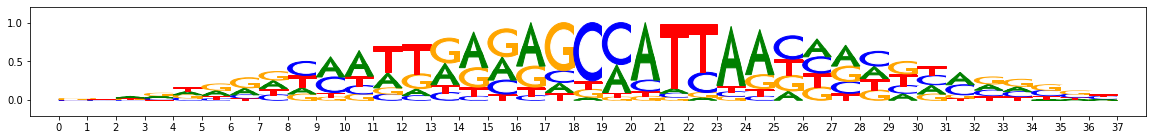

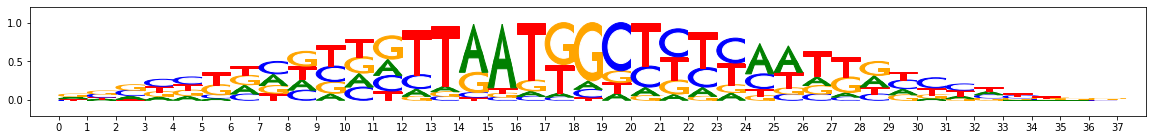

within v outside cluster jaccard sims


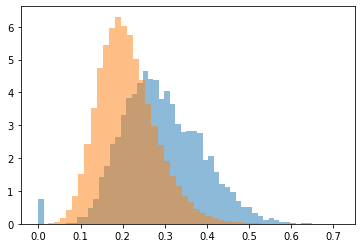

median within v outside cluster jaccard sims


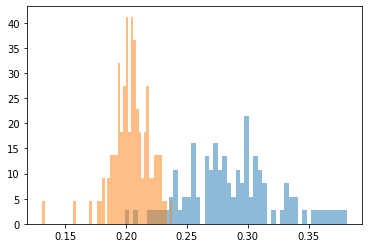

diff of median within v outside cluster jaccard sims


max within v outside cluster jaccard sims


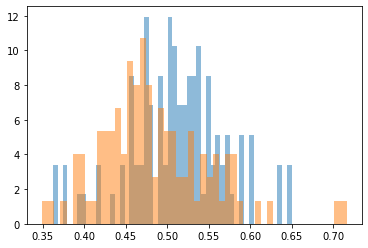

diff of max within v outside cluster jaccard sims


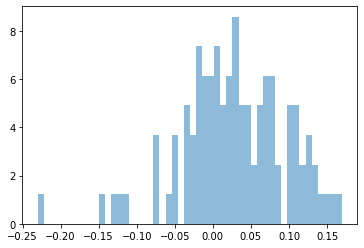

In [663]:

distmat = get_diffusion_distances(affmat=nearest_neighb_affmat(affmat=affmat,
                                                                      n_neighbs=[10,20,40]),
                                                               t=2)
"""Z = linkage(y=scipy.spatial.distance.squareform(distmat), method='ward')
the_clustering = fcluster(Z, 8, criterion='maxclust')-1"""

import umap
import leidenalg

#get Leiden averaged over different seeds
averaging_rounds = 0
current_affmat = 1.0/(distmat + 1.0)
for round_num in range(averaging_rounds):
    current_affmat = modisco.affinitymat.average_over_different_seeds(
                        affmat=current_affmat,
                        clustering_procedure=modisco.affinitymat.LeidenClustering(
                                                partitiontype=leidenalg.ModularityVertexPartition,
                                                n_iterations=1),
                        nseeds=200)

the_clustering = modisco.affinitymat.take_best_over_different_seeds(affmat=current_affmat,
                                                clustering_procedure=modisco.affinitymat.LeidenClustering(
                                                    partitiontype=leidenalg.ModularityVertexPartition,
                                                    n_iterations=1),
                                                nseeds=20)
print(Counter(the_clustering))

seqletimps = np.array([np.sum(x["contrib_scores"].corefwd) for x in seqlets])

print("Numbed of clusters:",np.max(the_clustering)+1)
for idx in range(max(the_clustering)+1):
    in_cluster_mask = idx==the_clustering
    
    print("Cluster idx",idx,"size",np.sum(in_cluster_mask))
    if (np.sum(in_cluster_mask) > 20):
        #find an exemplar for the cluster as the one with the minimum total distance to all the others
        #ok this doesn't work that well
        #exemplar = np.argmin(np.sum(distmat[:,in_cluster_mask],axis=-1)+((in_cluster_mask==False)*np.inf))
        exemplar = np.argmax(seqletimps*in_cluster_mask) #highest imp for exemplar - this works better

        distsortinfo = np.argsort(distmat[in_cluster_mask, exemplar])
        isfwdinfo = isfwdmat[in_cluster_mask,exemplar][distsortinfo]
        offsetsinfo = offsets[in_cluster_mask,exemplar][distsortinfo]
        seqlets_in_cluster_allfwd_unsorted = [seqlet for seqlet,incluster in zip(seqlets, in_cluster_mask) if incluster]
        seqlets_in_cluster_allfwd = [seqlets_in_cluster_allfwd_unsorted[i] for i in distsortinfo]
        oriented_seqlets_in_cluster = [(seqlet if isfwd==True else seqlet.get_revcomp())
                                       for (seqlet, isfwd) in zip(seqlets_in_cluster_allfwd, isfwdinfo)]
        #for aseqlet in oriented_seqlets_in_cluster[:3]:
        #    viz_sequence.plot_weights(aseqlet["contrib_scores"].corefwd)
        aggregated_seqlet = modisco.core.AggregatedSeqlet(seqlets=oriented_seqlets_in_cluster[:100],
                                                          offsets=offsetsinfo[:100])
        viz_sequence.plot_weights(aggregated_seqlet["contrib_scores"].fwd)
        viz_sequence.plot_weights(aggregated_seqlet["meannormcontrib_scores"].fwd)
        viz_sequence.plot_weights(aggregated_seqlet["meannormhypcontrib_scores"].fwd)
        print("onehot")
        viz_sequence.plot_weights(aggregated_seqlet["onehot"].fwd)
        viz_sequence.plot_weights(aggregated_seqlet["onehot"].rev)
        #plot the distribution of pairwise dissimilarities within the cluster
        zerodiagaffmat = affmat*(1-np.eye(affmat.shape[0]))
        print("within v outside cluster jaccard sims")
        plt.hist(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask].ravel(), bins=50, density=True, alpha=0.5)
        plt.hist(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask==False].ravel(), bins=50, density=True, alpha=0.5)
        plt.show()
        print("median within v outside cluster jaccard sims")
        plt.hist(np.median(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask],axis=-1), bins=50, density=True, alpha=0.5)
        plt.hist(np.median(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask==False],axis=-1), bins=50, density=True, alpha=0.5)
        plt.show()
        print("diff of median within v outside cluster jaccard sims")
        plt.hist(np.median(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask],axis=-1)
                 - np.median(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask==False],axis=-1), bins=50, density=True, alpha=0.5)
        plt.show()
        print("max within v outside cluster jaccard sims")
        plt.hist(np.max(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask],axis=-1), bins=50, density=True, alpha=0.5)
        plt.hist(np.max(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask==False],axis=-1), bins=50, density=True, alpha=0.5)
        plt.show()
        print("diff of max within v outside cluster jaccard sims")
        plt.hist(np.max(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask],axis=-1)
                 - np.max(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask==False],axis=-1), bins=50, density=True, alpha=0.5)
        plt.show()

[223, 754, 145, 838, 557, 804, 484, 306, 379, 554]
Exemplar 0 seqlet 223


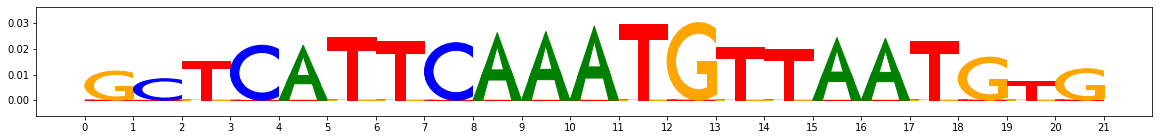

Cluster size: 80


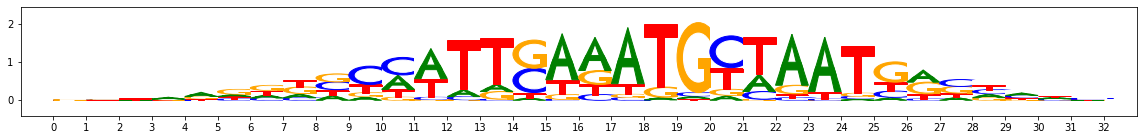

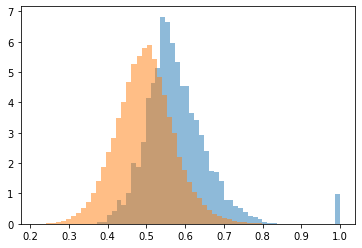

Exemplar 1 seqlet 754


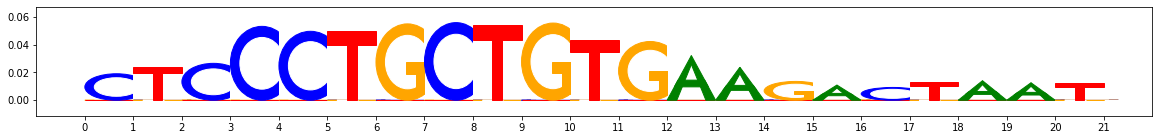

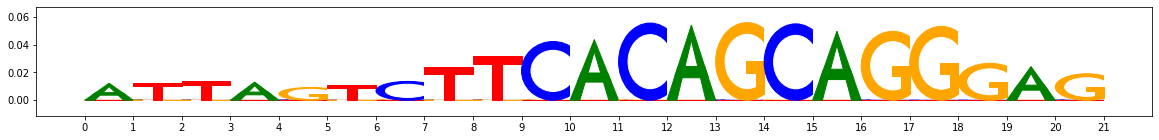

Cluster size: 120


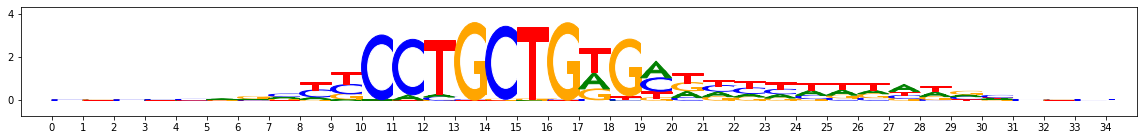

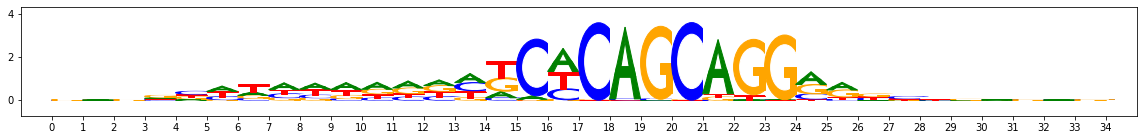

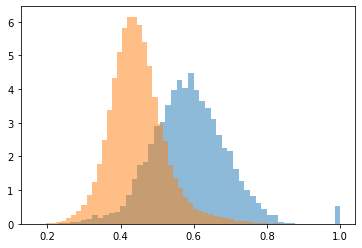

Exemplar 2 seqlet 145


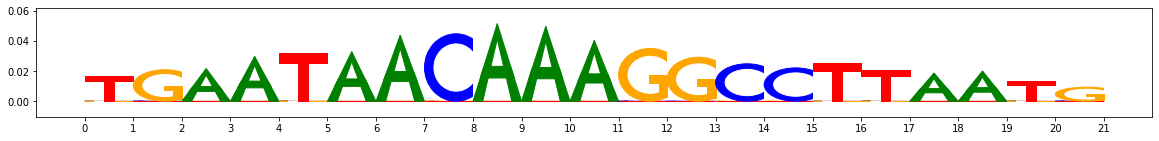

Cluster size: 139


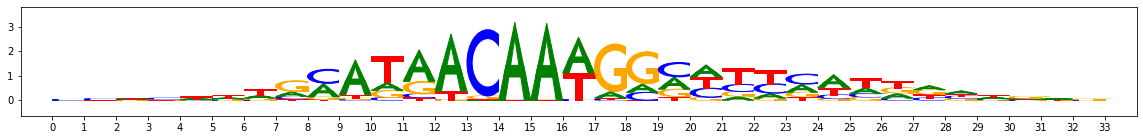

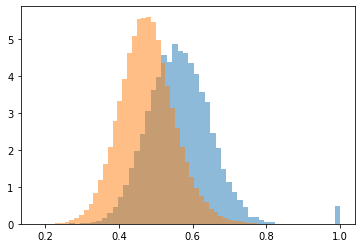

Exemplar 3 seqlet 838


Cluster size: 82


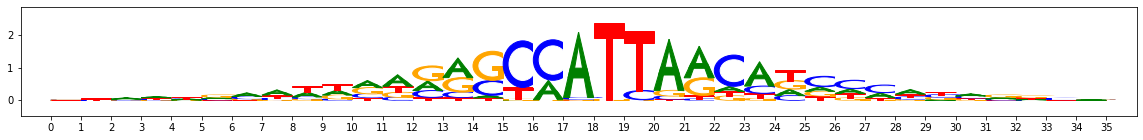

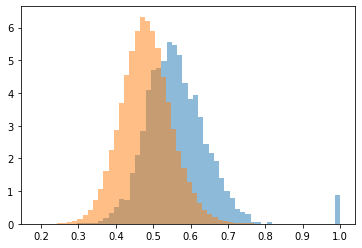

Exemplar 4 seqlet 557


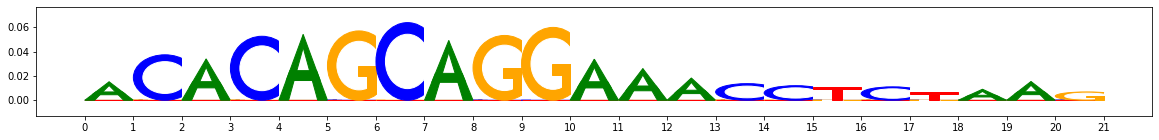

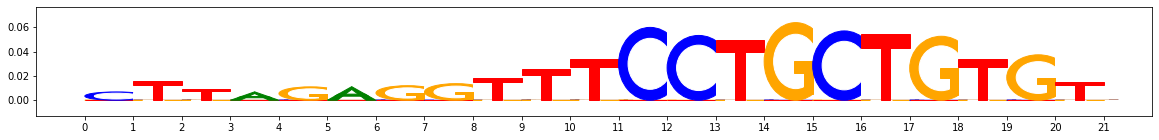

Cluster size: 106


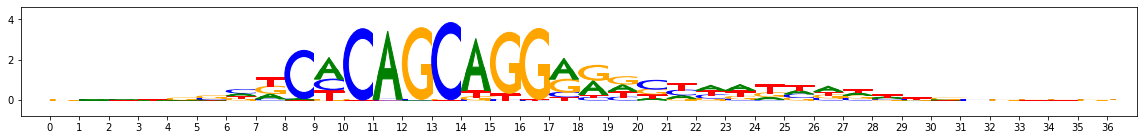

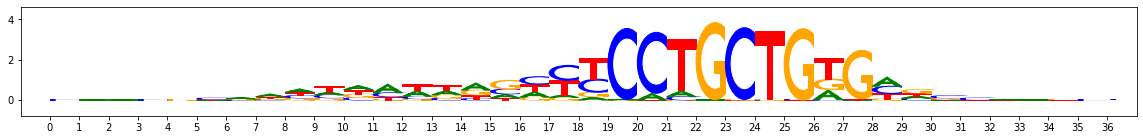

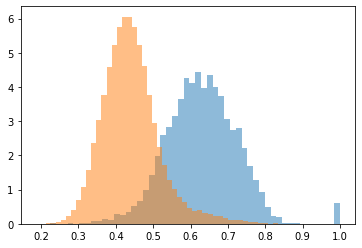

Exemplar 5 seqlet 804


Cluster size: 90


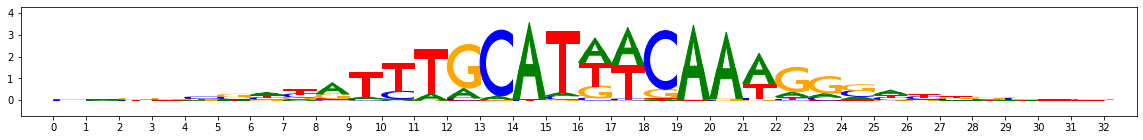

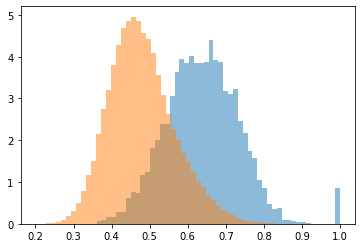

Exemplar 6 seqlet 484


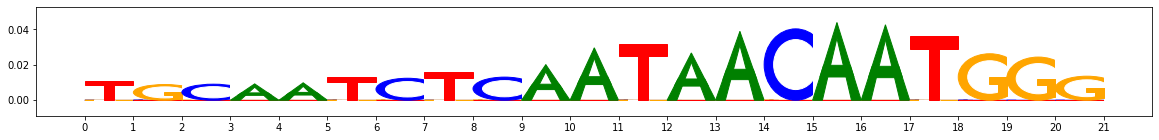

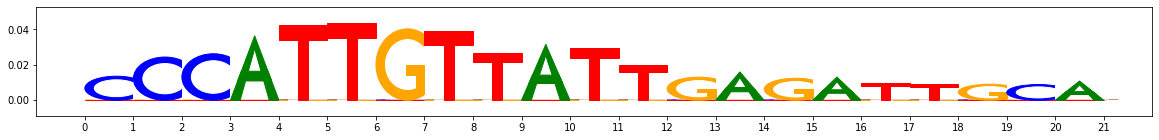

Cluster size: 95


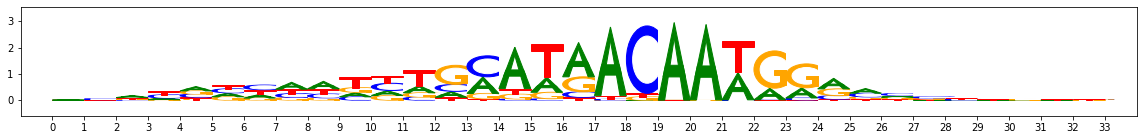

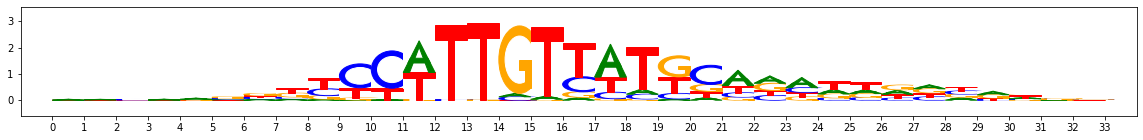

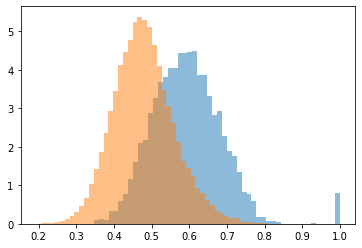

Exemplar 7 seqlet 306


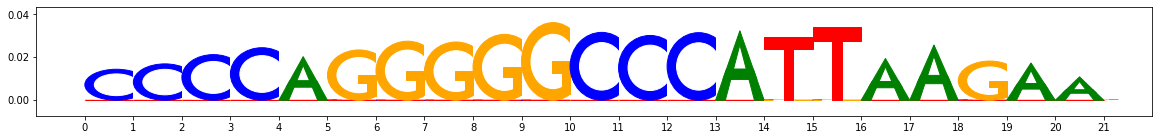

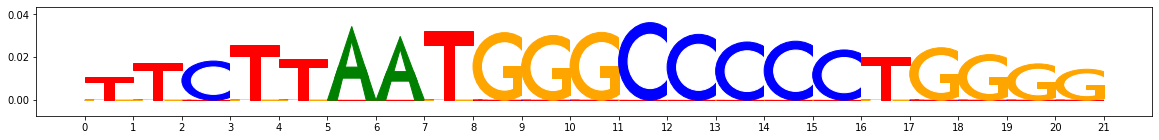

Cluster size: 73


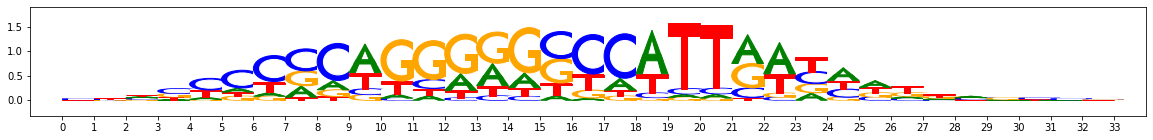

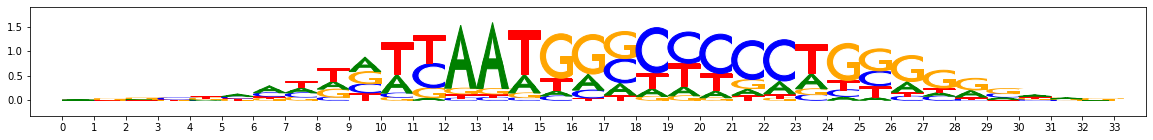

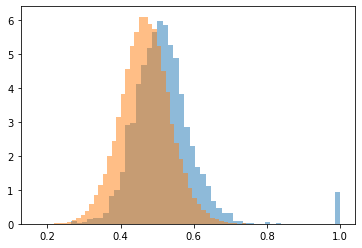

Exemplar 8 seqlet 379


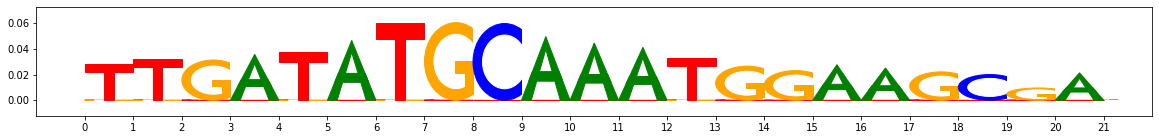

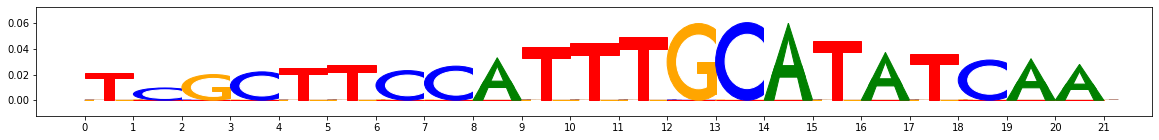

Cluster size: 68


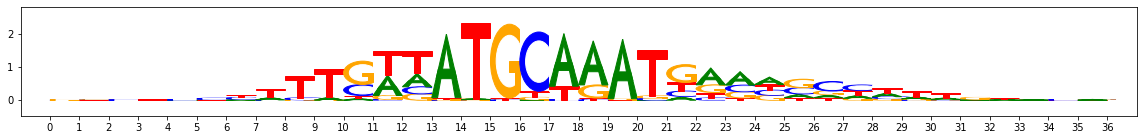

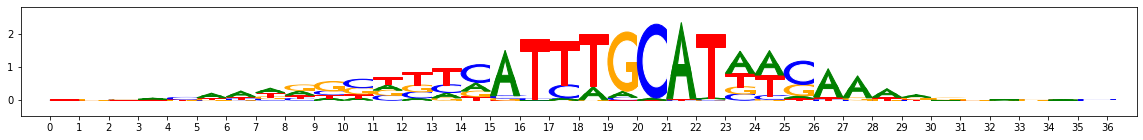

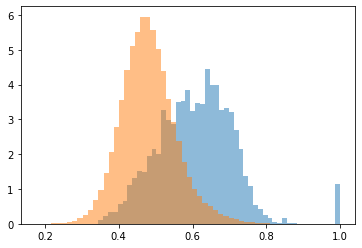

Exemplar 9 seqlet 554


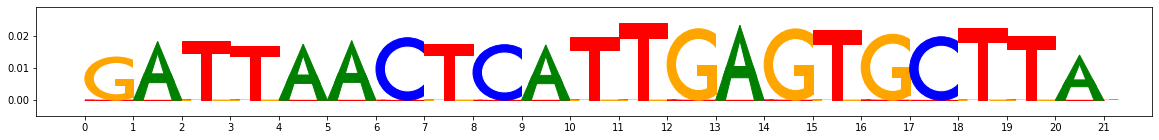

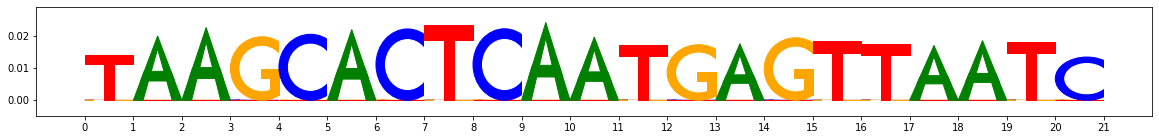

Cluster size: 83


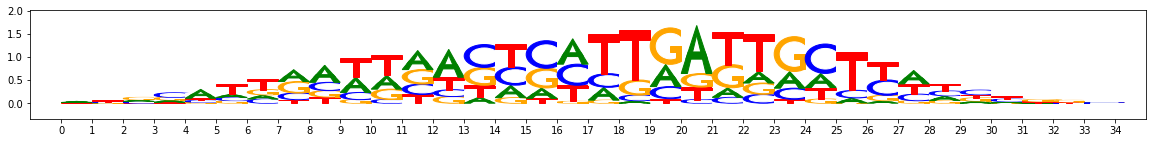

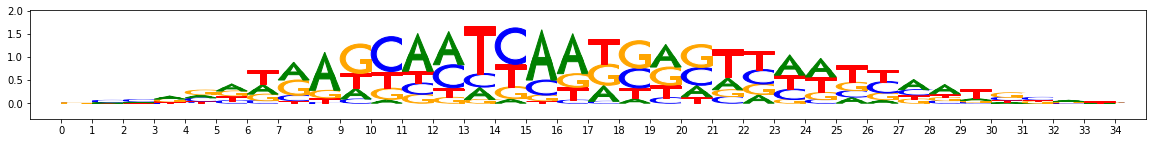

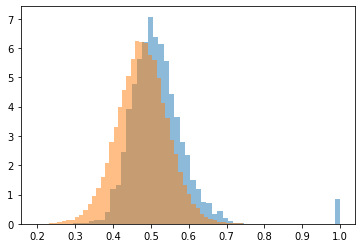

In [71]:
import modisco.core
reload(modisco.core)
import numpy as np
import modisco.util
reload(modisco.util)
from matplotlib import pyplot as plt
from sklearn_extra.cluster import KMedoids

num_exemplars = 10


submodular_exemplars = modisco.util.facility_locator(distmat, num_exemplars)
print(submodular_exemplars)
exemplars = submodular_exemplars
#exemplars = KMedoids(n_clusters=num_exemplars,
#                     metric='precomputed', init='random', random_state=10).fit(distmat).medoid_indices_
#print(exemplars)

exemplar_clusters = np.argmin(distmat[:,exemplars[:num_exemplars]], axis=1)

for exemplar_idx,exemplar in enumerate(exemplars[:num_exemplars]):
    print("Exemplar",exemplar_idx,"seqlet",exemplar)
    viz_sequence.plot_weights(seqlets[exemplar]["contrib_scores"].corefwd)
    viz_sequence.plot_weights(seqlets[exemplar].get_revcomp()["contrib_scores"].corefwd)
    in_cluster_mask = exemplar_clusters==exemplar_idx
    print("Cluster size:",sum(in_cluster_mask))
    #can get the seqlets + their alignment to the exemplar
    distsortinfo = np.argsort(distmat[in_cluster_mask, exemplar])
    isfwdinfo = isfwdmat[in_cluster_mask,exemplar][distsortinfo]
    offsetsinfo = offsets[in_cluster_mask,exemplar][distsortinfo]
    seqlets_in_cluster_allfwd_unsorted = [seqlet for seqlet,incluster in zip(seqlets, in_cluster_mask) if incluster]
    seqlets_in_cluster_allfwd = [seqlets_in_cluster_allfwd_unsorted[i] for i in distsortinfo]
    oriented_seqlets_in_cluster = [(seqlet if isfwd==True else seqlet.get_revcomp())
                                   for (seqlet, isfwd) in zip(seqlets_in_cluster_allfwd, isfwdinfo)]
    #for aseqlet,anoffset,isfwd in list(zip(oriented_seqlets_in_cluster, offsetsinfo, isfwdinfo))[:3]:
    #    print("offset:",anoffset,"isfwd:",isfwd)
    #    viz_sequence.plot_weights(aseqlet["contrib_scores"].corefwd)
    
    aggregated_seqlet = modisco.core.AggregatedSeqlet(seqlets=oriented_seqlets_in_cluster[:100],
                                                      offsets=offsetsinfo[:100])
    viz_sequence.plot_weights(aggregated_seqlet["contrib_scores"].fwd)
    viz_sequence.plot_weights(aggregated_seqlet["contrib_scores"].rev)
    #plot the distribution of pairwise dissimilarities within the cluster
    plt.hist(affmat[in_cluster_mask][:,in_cluster_mask].ravel(), bins=50, density=True, alpha=0.5)
    plt.hist(affmat[in_cluster_mask][:,in_cluster_mask==False].ravel(), bins=50, density=True, alpha=0.5)
    plt.show()
    

In [43]:
#do a tsne embedding
import sklearn.manifold

embedding_tsnep10 = sklearn.manifold.TSNE(perplexity=10, metric='precomputed').fit_transform(distmat)
embedding_tsnep30 = sklearn.manifold.TSNE(perplexity=30, metric='precomputed').fit_transform(distmat)

In [51]:
import umap

embedding_umap10 = umap.UMAP(n_neighbors=10, min_dist=0, metric='precomputed').fit_transform(distmat)
embedding_umap30 = umap.UMAP(n_neighbors=30, min_dist=0, metric='precomputed').fit_transform(distmat)

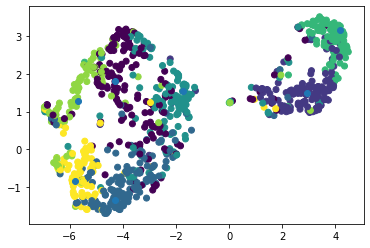

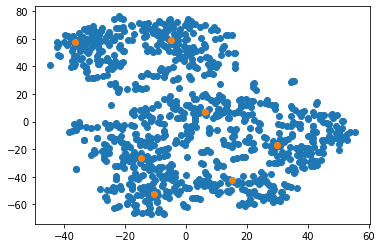

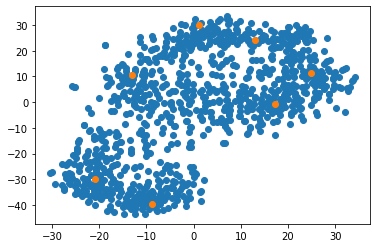

In [70]:
from matplotlib import pyplot as plt

num_exemplars=7
exemplar_clusters = np.argmin(distmat[exemplars[:num_exemplars]], axis=0)

plt.scatter(embedding_umap10[:,0], embedding_umap10[:,1], c=exemplar_clusters)
plt.scatter(embedding_umap10[exemplars[:num_exemplars],0],
            embedding_umap10[exemplars[:num_exemplars],1])
plt.show()
plt.scatter(embedding_umap30[:,0],embedding_umap30[:,1])
plt.scatter(embedding_umap30[exemplars[:num_exemplars],0],
            embedding_umap30[exemplars[:num_exemplars],1])
plt.show()
plt.scatter(embedding_tsnep10[:,0], embedding_tsnep10[:,1])
plt.scatter(embedding_tsnep10[exemplars[:num_exemplars],0],
            embedding_tsnep10[exemplars[:num_exemplars],1])
plt.show()
plt.scatter(embedding_tsnep30[:,0], embedding_tsnep30[:,1])
plt.scatter(embedding_tsnep30[exemplars[:num_exemplars],0],
            embedding_tsnep30[exemplars[:num_exemplars],1])
plt.show()

0 1.0 0 True
corefwd 0


547 0.8441747375705171 2 False
corerev 547


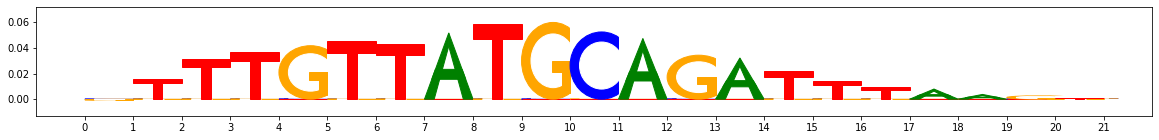

907 0.8334903720889061 7 True
corefwd 907


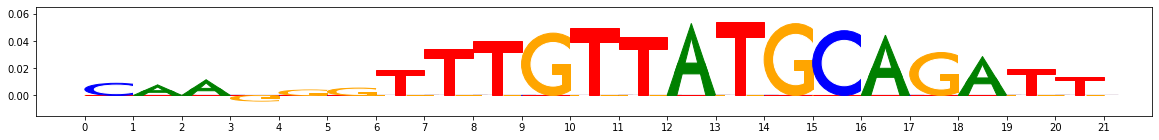

475 0.8186446704247554 6 False
corerev 475


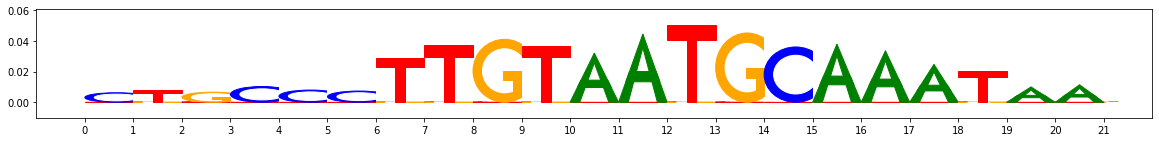

207 0.7950378773184481 4 False
corerev 207


4 0.7881062737737318 2 False
corerev 4


140 0.7758293175682531 4 False
corerev 140


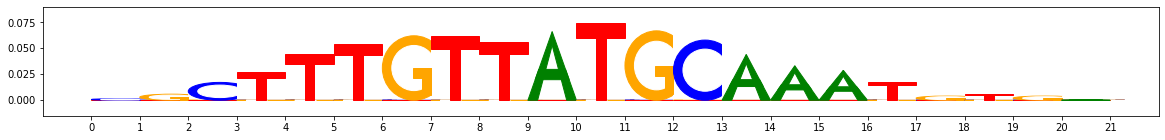

687 0.771442663832151 2 False
corerev 687


854 0.7664492014184281 0 False
corerev 854


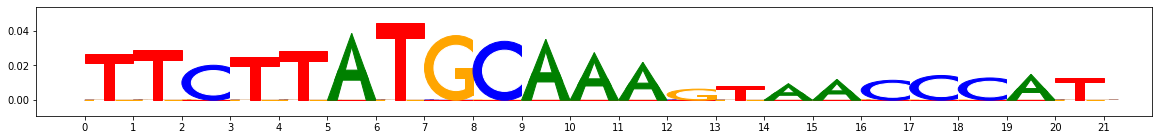

643 0.7650440290506103 1 True
corefwd 643


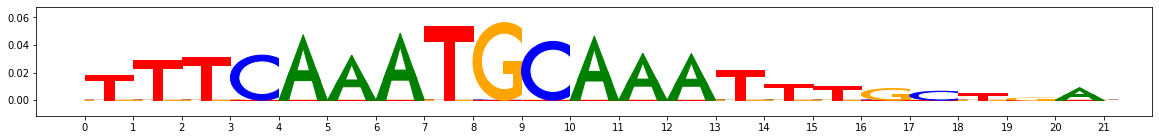

In [74]:
from modisco.visualization import viz_sequence

arow = affmat[0,:]
offsetsinrow = offsets[0,:]
isfwdrow = isfwdmat[0,:]
seqletssubset = seqlets[:]
sortedindices = np.argsort(arow)[::-1]
for idx in sortedindices[:10]:
    print(idx,arow[idx], offsetsinrow[idx], isfwdrow[idx])
    if (isfwdrow[idx]):
        print("corefwd",idx)
        viz_sequence.plot_weights(seqletssubset[idx]["contrib_scores"].corefwd)
    else:
        print("corerev",idx)
        viz_sequence.plot_weights(seqletssubset[idx]["contrib_scores"].corerev)

In [271]:
def compute_sim_on_pair(seqldat1, seqldat2, min_overlap_frac, pair_sim_metric): 
                                                                                
    if (seqldat1.corelen <= seqldat2.corelen):                                  
        shortr_seqldat = seqldat1                                               
        longer_seqldat = seqldat2                                               
    else:                                                                       
        shortr_seqldat = seqldat2                                               
        longer_seqldat = seqldat1                                               
    assert (shortr_seqldat.corelen <= longer_seqldat.corelen)                   
                                                                                
    shortrcorelen = shortr_seqldat.corelen                                      
    longercorelen = longer_seqldat.corelen                                      
    shortrflanklen = shortr_seqldat.flanklen                                    
    longerflanklen = longer_seqldat.flanklen                                    
    shortronehot, shortrhyp = shortr_seqldat.onehot, shortr_seqldat.hyp         
    longeronehot, longerhyp = longer_seqldat.onehot, longer_seqldat.hyp         
                                                                                
    shortractual = shortronehot*shortrhyp                                       
    longeractual = longeronehot*longerhyp                                       
                                                                                
    shortrcorelen = len(shortronehot)-2*shortrflanklen                          
    longercorelen = len(longeronehot)-2*longerflanklen                          
    min_overlap = int(shortrcorelen*min_overlap_frac)                           
                                                                                
    #iterate over all possible offsets of                                       
    # shortr's core relative to longerdata                                      
    leftoffset = -(shortrcorelen-min_overlap)                                   
    rightoffset = longercorelen-min_overlap                                     
                                                                                
    possible_offsets = list(range(leftoffset, rightoffset+1))                   
    sim_results = []                                                            
    for offset in possible_offsets:                                             
        shortr_leftflank = max(offset,0)                                        
        shortr_rightflank = max(longercorelen-(offset+shortrcorelen),0)         
                                                                                
        shortr_slicestart = shortrflanklen-shortr_leftflank                     
        shortr_sliceend = shortrflanklen+shortrcorelen+shortr_rightflank        
                                                                                
        longer_leftflank = max(-offset,0)                                       
        longer_rightflank = max((offset+shortrcorelen)-longercorelen,0)         
        longer_slicestart = longerflanklen-longer_leftflank                     
        longer_sliceend = longerflanklen+longercorelen+longer_rightflank        
                                                                                
        shortractual_slice = shortractual[shortr_slicestart:shortr_sliceend]    
        shortronehot_slice = shortronehot[shortr_slicestart:shortr_sliceend]    
        shortrhyp_slice = shortrhyp[shortr_slicestart:shortr_sliceend]
        longeractual_slice = longeractual[longer_slicestart:longer_sliceend]    
        longeronehot_slice = longeronehot[longer_slicestart:longer_sliceend]    
        longerhyp_slice = longerhyp[longer_slicestart:longer_sliceend]          
                                                                                
        shortr_imputed = shortrhyp_slice*longeronehot_slice                     
        longer_imputed = longerhyp_slice*shortronehot_slice                     
        
        print("offset:",offset)
        print("s1 s2 onehot")
        viz_sequence.plot_weights(shortronehot_slice)
        viz_sequence.plot_weights(longeronehot_slice)
        print("s1 s2 hyp")
        viz_sequence.plot_weights(shortrhyp_slice)
        viz_sequence.plot_weights(longerhyp_slice)
        print("s1 s2 actual")
        viz_sequence.plot_weights(shortractual_slice)
        viz_sequence.plot_weights(longeractual_slice)
        print("s1 s2 imputed")
        viz_sequence.plot_weights(shortr_imputed)
        viz_sequence.plot_weights(longer_imputed)
        sim_results.append(                                                     
             0.5*pair_sim_metric(shortractual_slice, longer_imputed)            
           + 0.5*pair_sim_metric(shortr_imputed, longeractual_slice))           
                                                                                
    return max(sim_results)

In [272]:
onehot_trackname="onehot"
hyp_trackname="hypcontrib_scores"
max_seqlet_len = max(len(x) for x in seqlets)
min_overlap_frac=0.67
flank_sizes = [max_seqlet_len-int(len(seqlet)*min_overlap_frac)    
               for seqlet in seqlets]

allfwd_onehot_seqletdata = (np.array(                                   
                            [seqlet[onehot_trackname].get_core_with_flank(      
                             left=flank, right=flank, is_revcomp=False)         
                             for seqlet,flank in zip(seqlets,flank_sizes)])>0)  
allfwd_hyp_seqletdata = np.array(                                       
                            [seqlet[hyp_trackname].get_core_with_flank(         
                             left=flank, right=flank, is_revcomp=False)         
                             for seqlet,flank in zip(seqlets,flank_sizes)])
allrev_onehot_seqletdata = allfwd_onehot_seqletdata[:,::-1,::-1]
allrev_hyp_seqletdata = allfwd_hyp_seqletdata[:,::-1,::-1]

i=44
j=0
seqldat1 = modisco.affinitymat.SeqlDatForImput(corelen=len(seqlets[i]),                
                            onehot=allfwd_onehot_seqletdata[i],     
                            hyp=allfwd_hyp_seqletdata[i])          
seqldat2 = modisco.affinitymat.SeqlDatForImput(                            
                corelen=len(seqlets[j]),                
                onehot=allrev_onehot_seqletdata[j],     
                hyp=allrev_hyp_seqletdata[j])

def pair_l1norm_contin_jaccard_sim(arr1, arr2):                                      
    assert len(arr1.shape)==2, arr1.shape                                       
    assert arr1.shape[:]==arr2.shape[:], (arr1.shape, arr2.shape)             
    absarr1 = np.abs(arr1)                                                      
    absarr1 = absarr1/np.sum(absarr1) #l1 norm         
    absarr2 = np.abs(arr2)                                                      
    absarr2 = absarr2/np.sum(absarr2) #l1 norm         
    signarr1 = np.sign(arr1)                                                    
    signarr2 = np.sign(arr2)                                                    
    return (np.sum(np.minimum(absarr1,absarr2)*signarr1*signarr2)/  
            np.sum(np.maximum(absarr1, absarr2)))

offset: -7
s1 s2 onehot


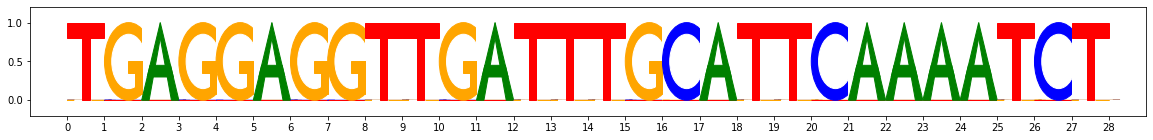

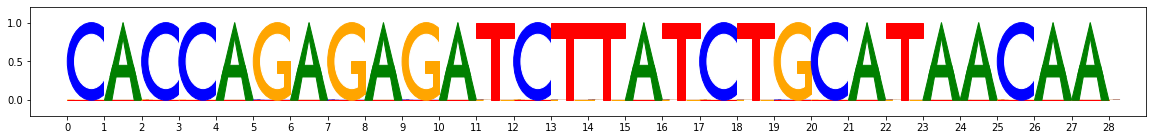

s1 s2 hyp


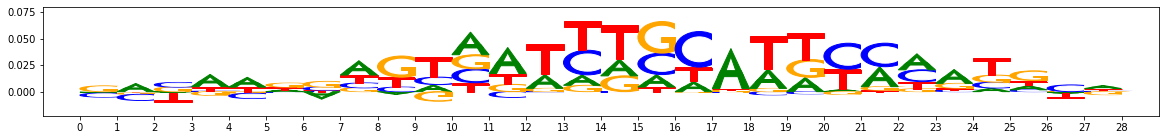

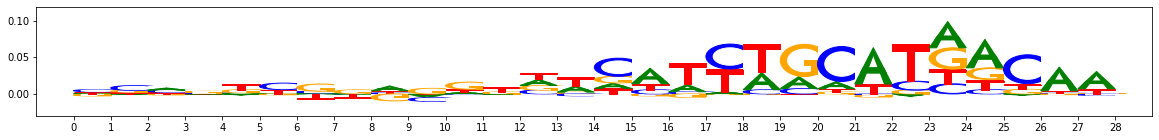

s1 s2 actual


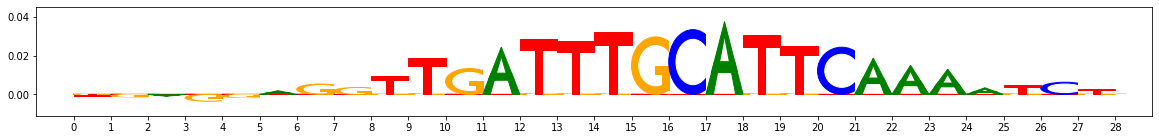

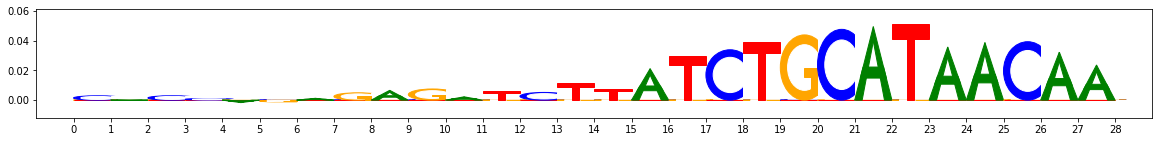

s1 s2 imputed


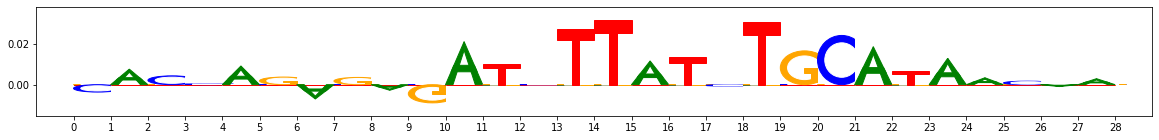

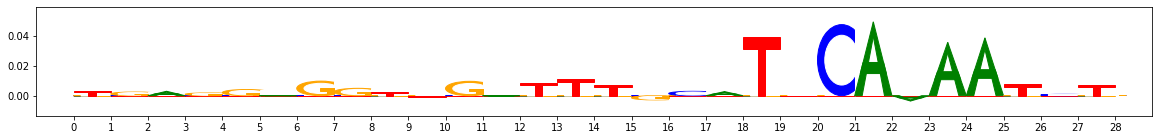

offset: -6
s1 s2 onehot


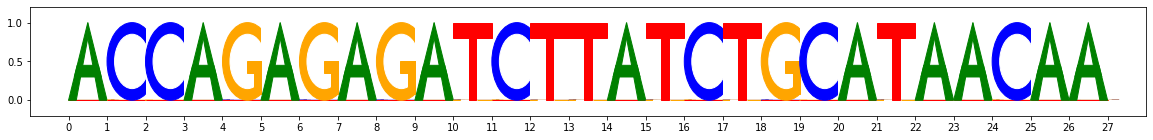

s1 s2 hyp


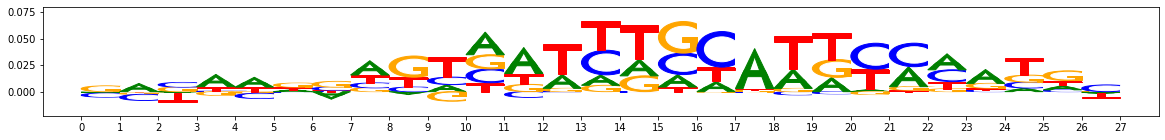

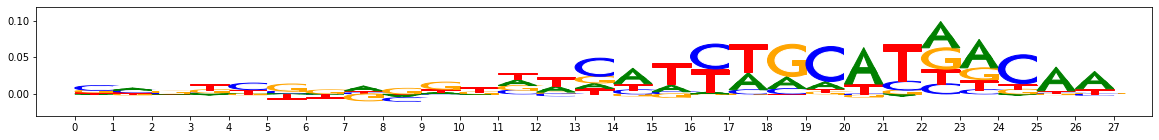

s1 s2 actual


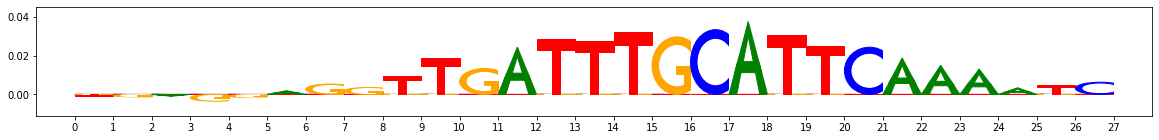

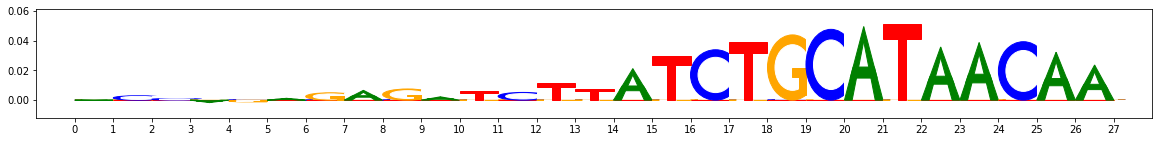

s1 s2 imputed


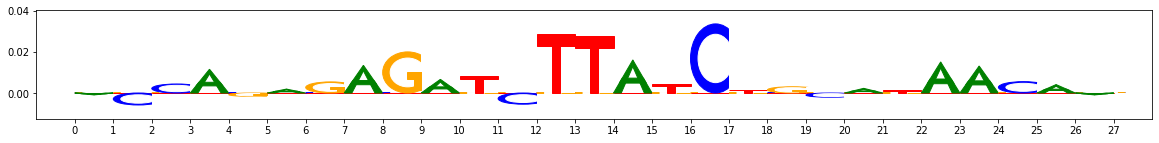

offset: -5
s1 s2 onehot


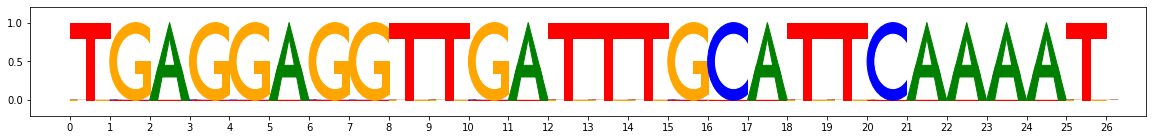

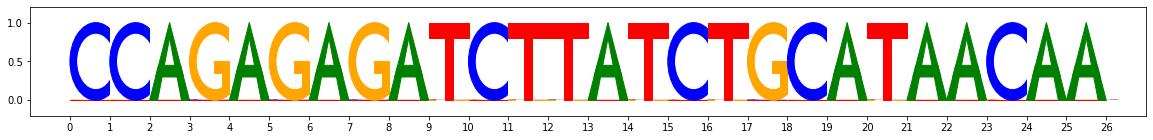

s1 s2 hyp


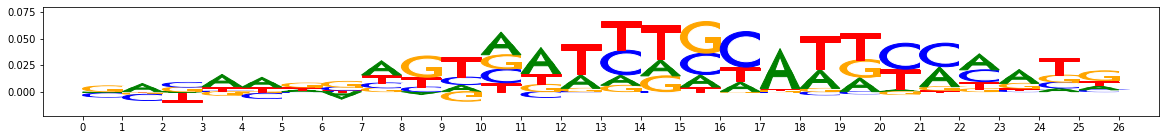

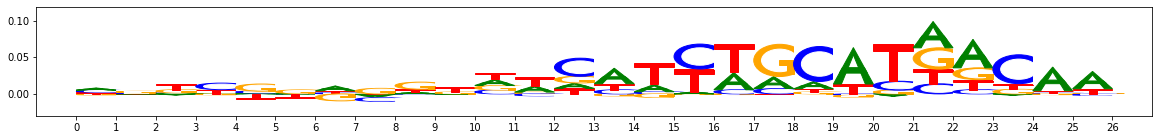

s1 s2 actual


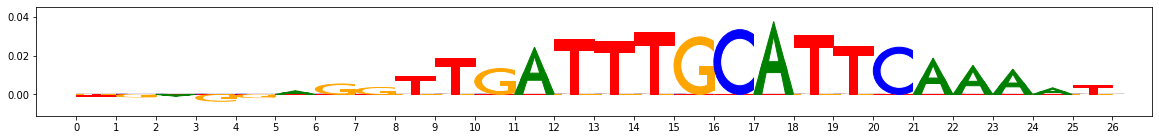

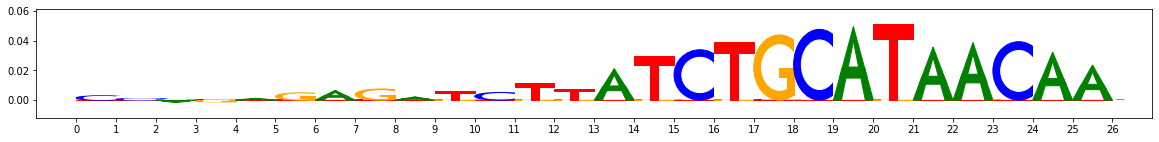

s1 s2 imputed


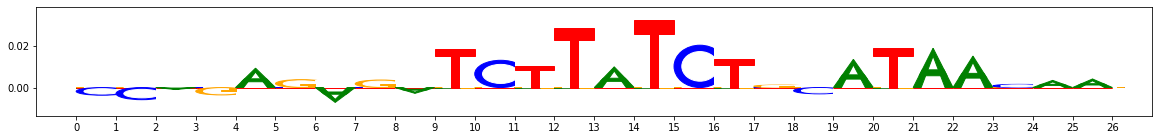

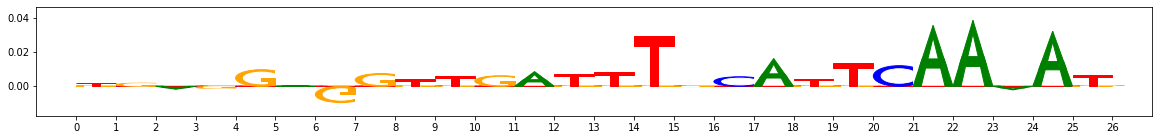

offset: -4
s1 s2 onehot


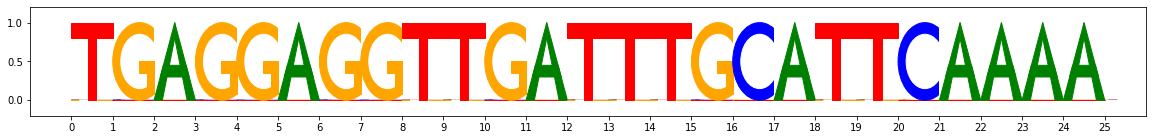

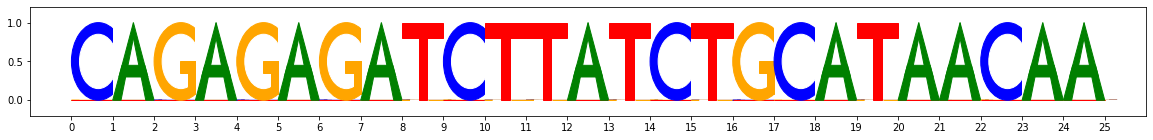

s1 s2 hyp


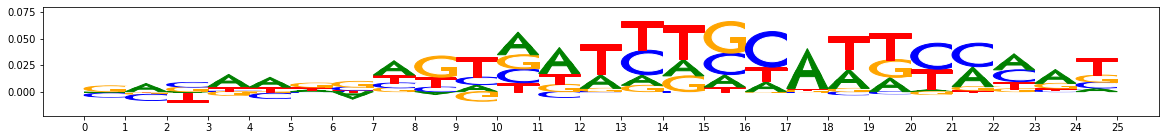

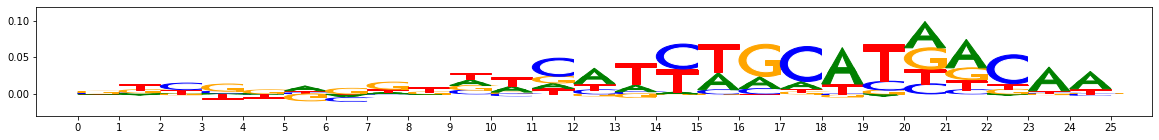

s1 s2 actual


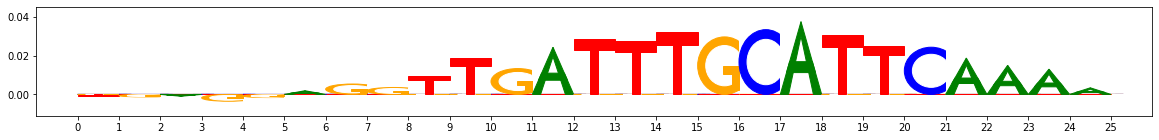

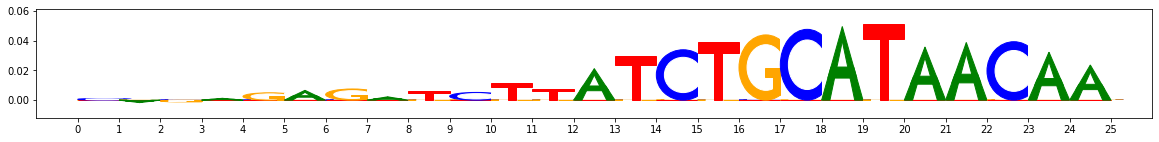

s1 s2 imputed


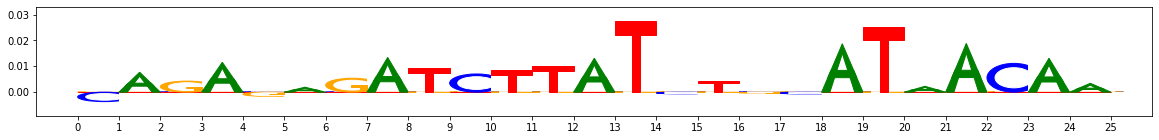

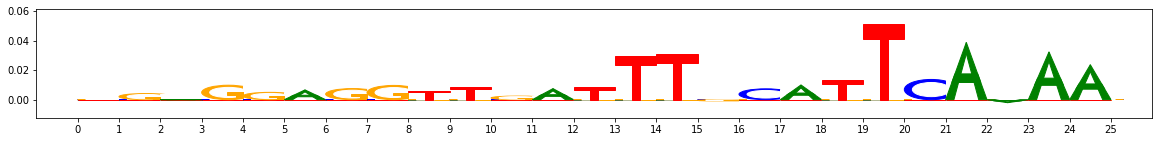

offset: -3
s1 s2 onehot


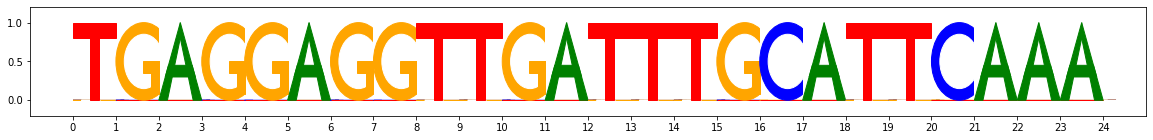

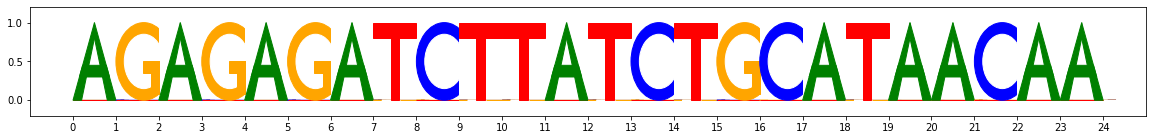

s1 s2 hyp


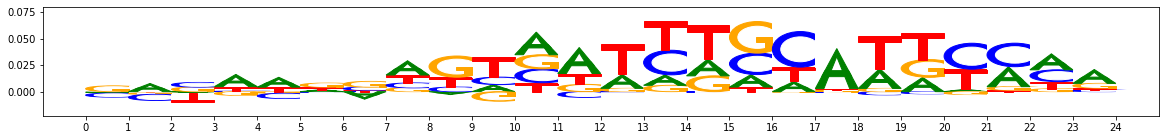

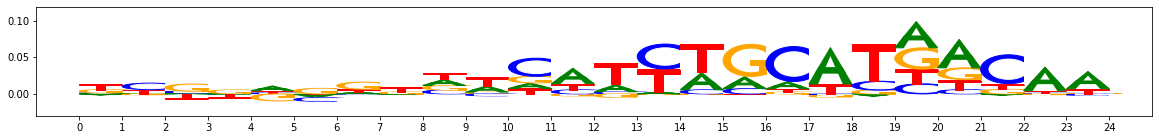

s1 s2 actual


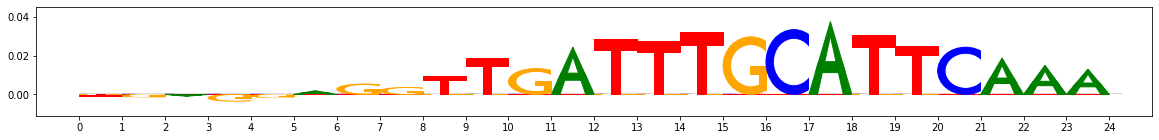

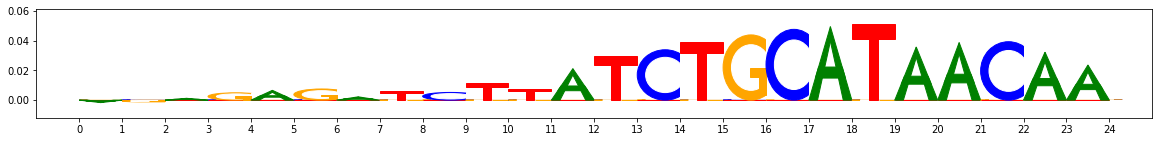

s1 s2 imputed


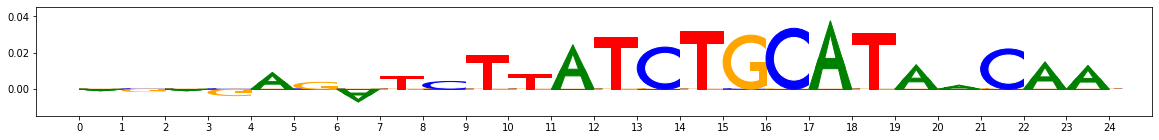

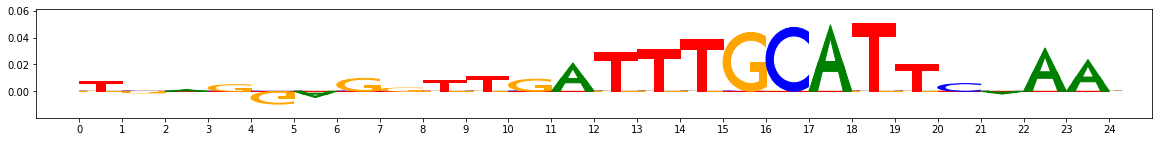

offset: -2
s1 s2 onehot


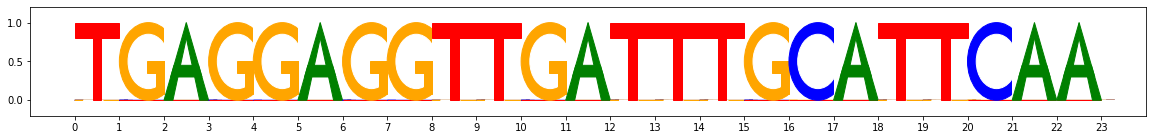

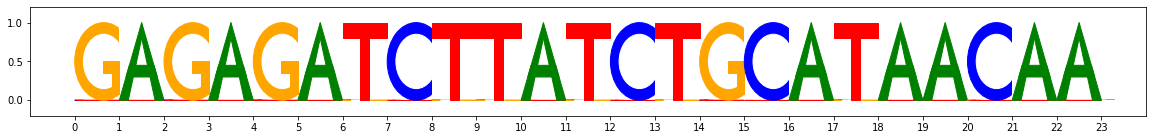

s1 s2 hyp


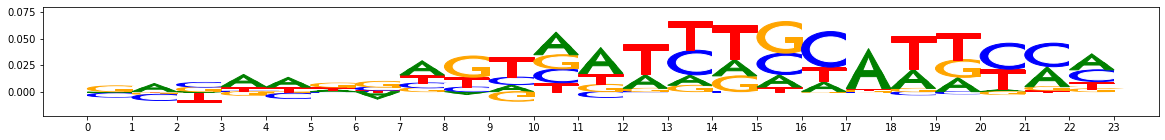

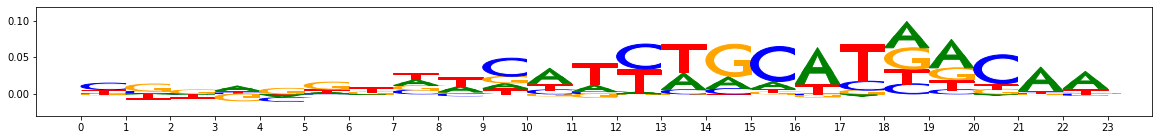

s1 s2 actual


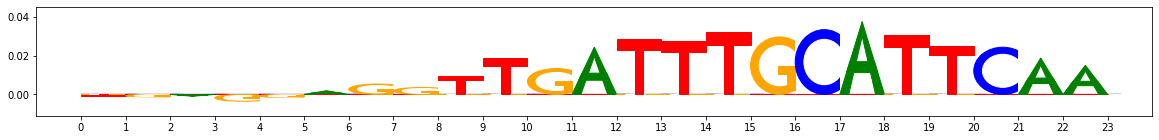

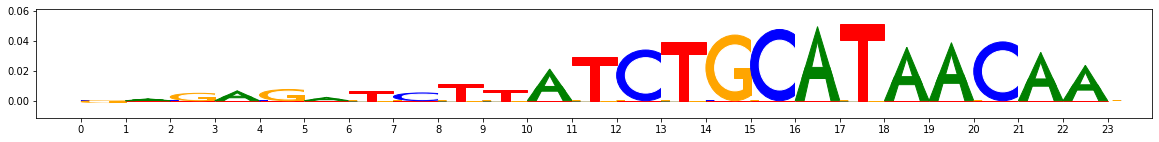

s1 s2 imputed


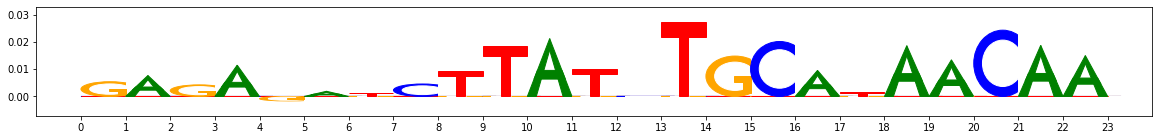

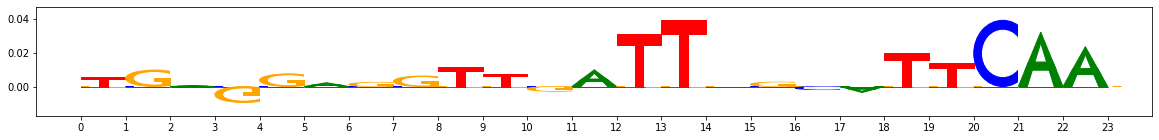

offset: -1
s1 s2 onehot


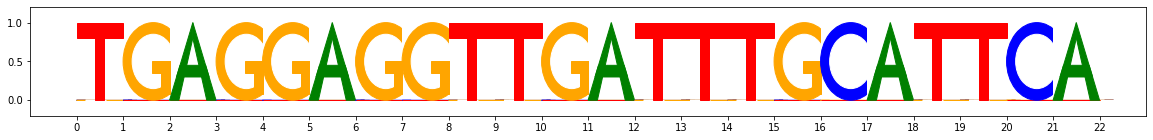

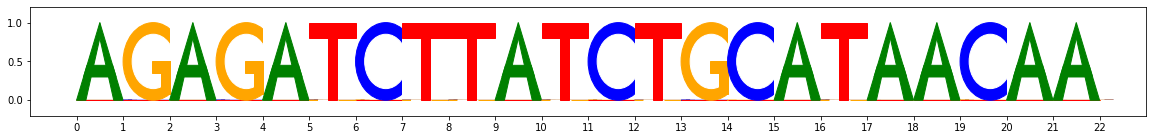

s1 s2 hyp


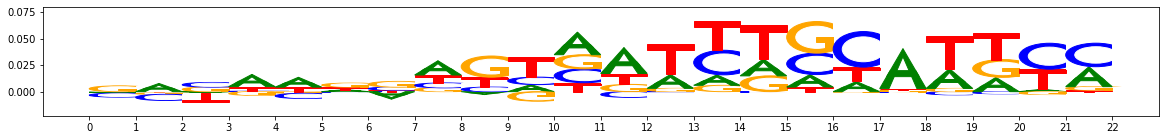

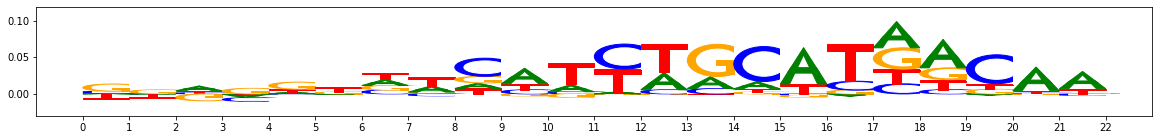

s1 s2 actual


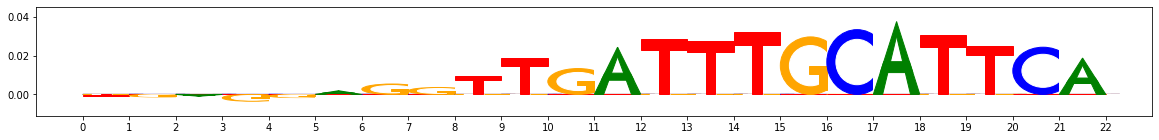

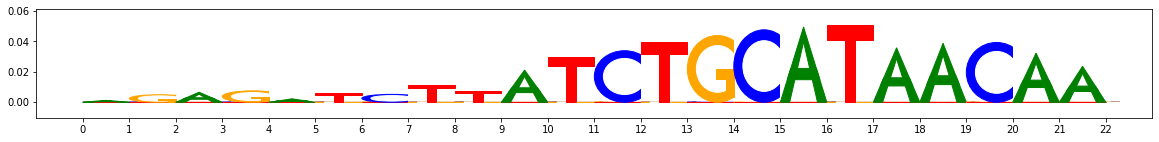

s1 s2 imputed


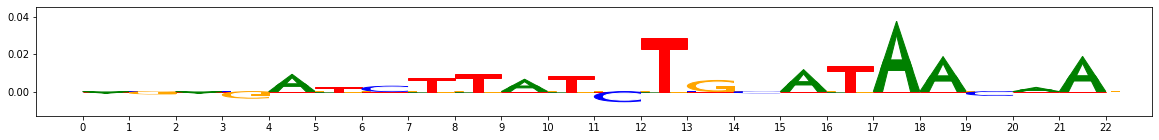

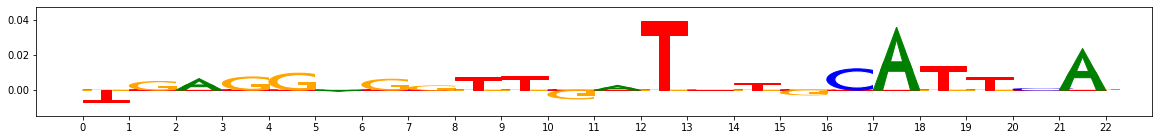

offset: 0
s1 s2 onehot


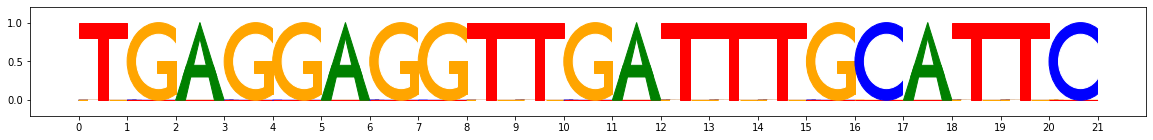

s1 s2 hyp


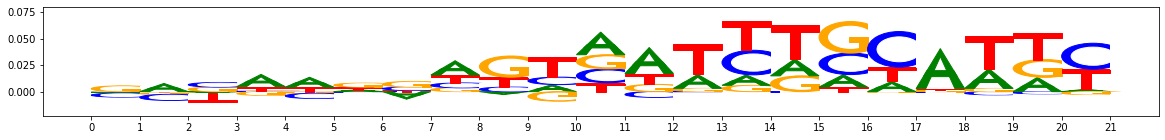

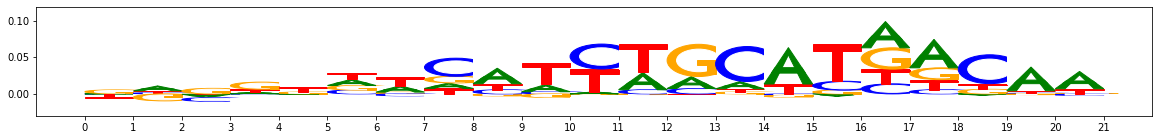

s1 s2 actual


s1 s2 imputed


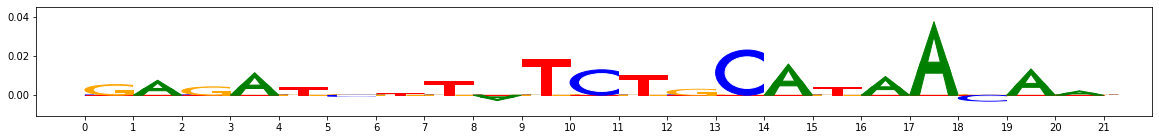

offset: 1
s1 s2 onehot


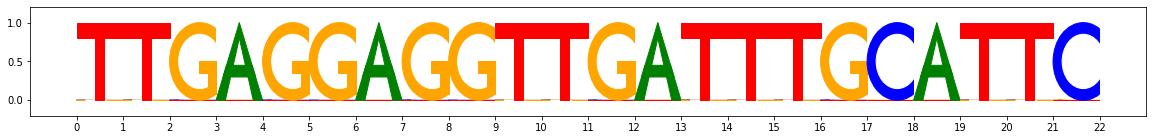

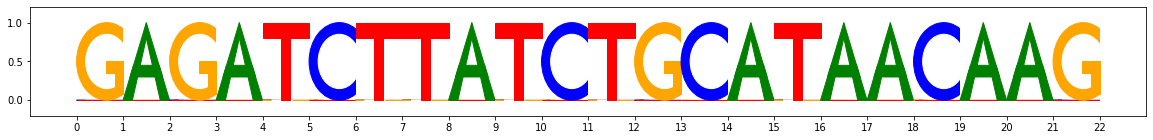

s1 s2 hyp


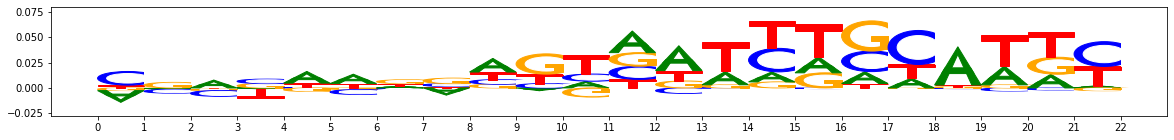

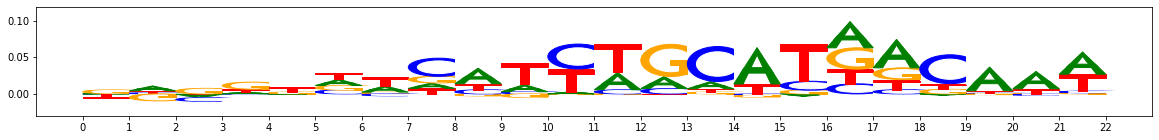

s1 s2 actual


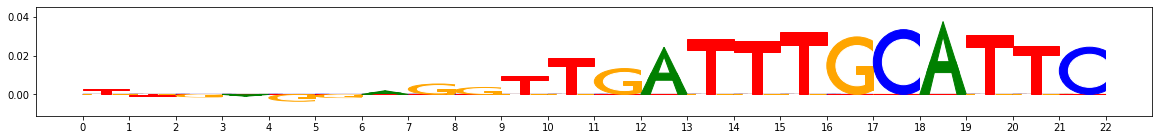

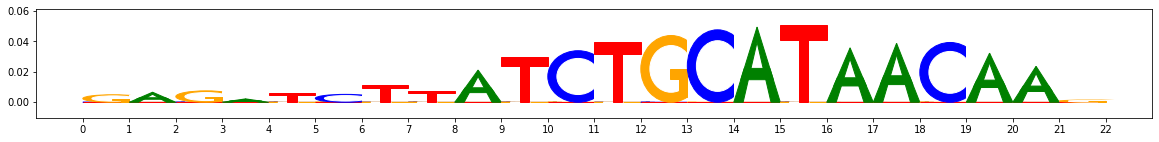

s1 s2 imputed


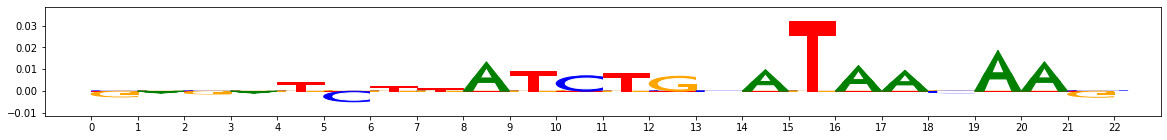

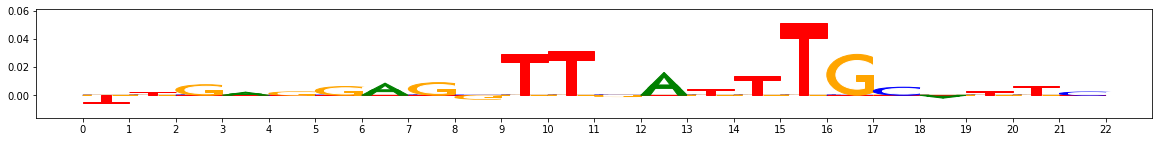

offset: 2
s1 s2 onehot


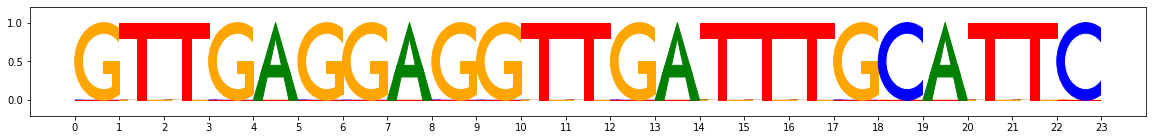

s1 s2 hyp


s1 s2 actual


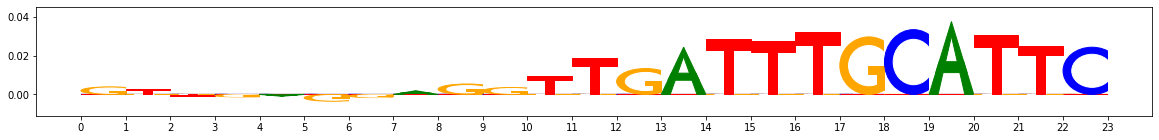

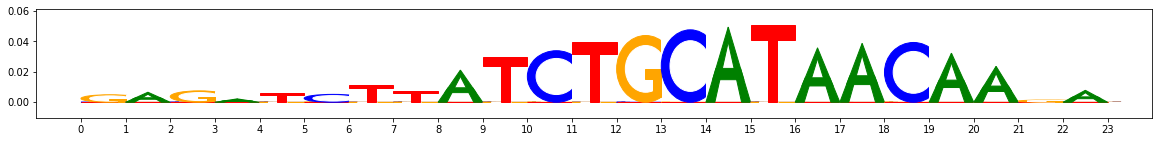

s1 s2 imputed


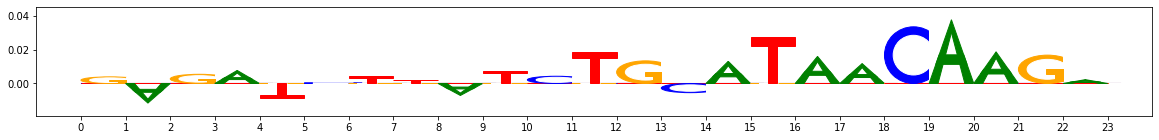

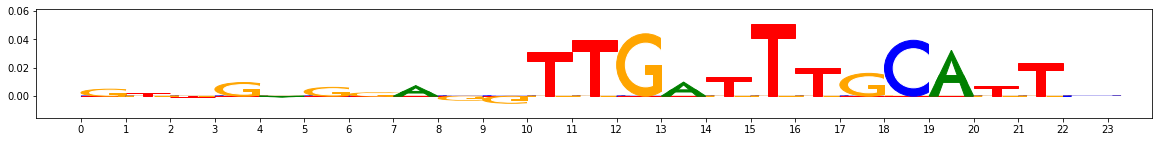

offset: 3
s1 s2 onehot


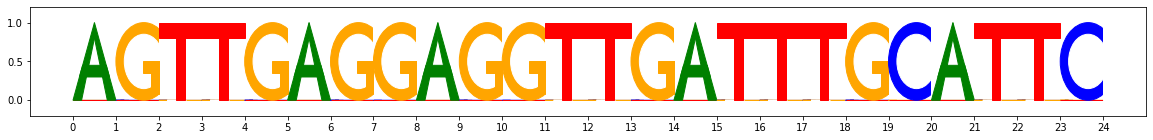

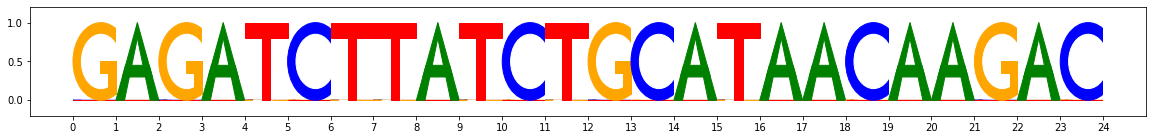

s1 s2 hyp


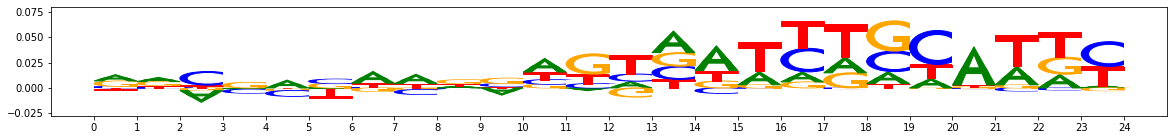

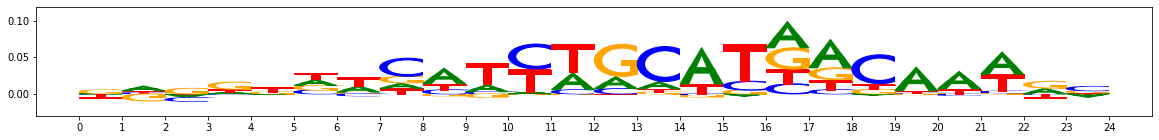

s1 s2 actual


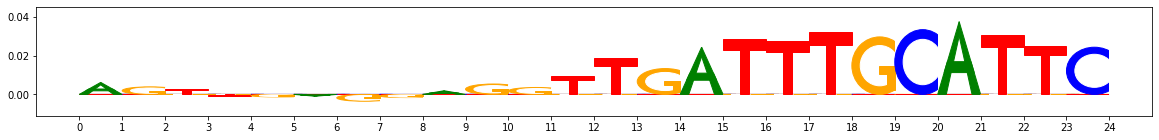

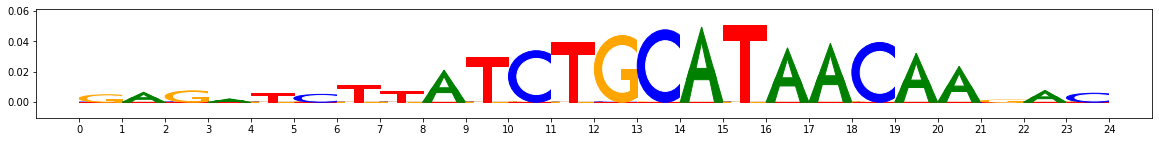

s1 s2 imputed


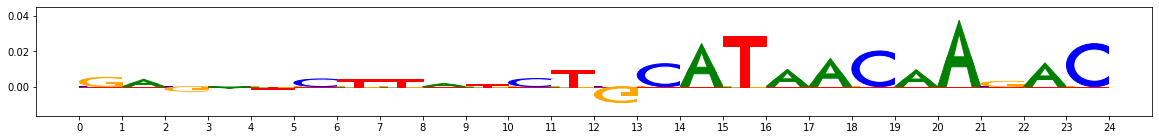

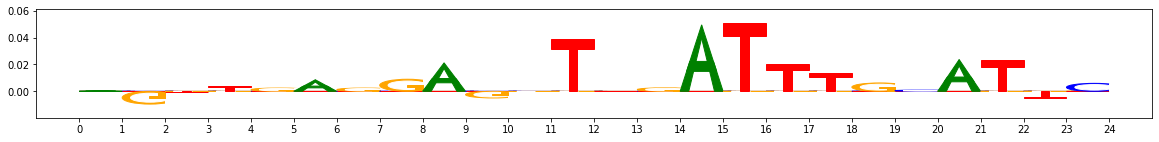

offset: 4
s1 s2 onehot


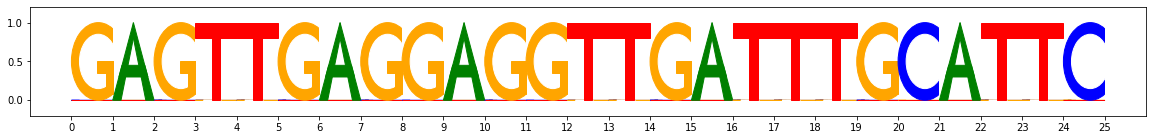

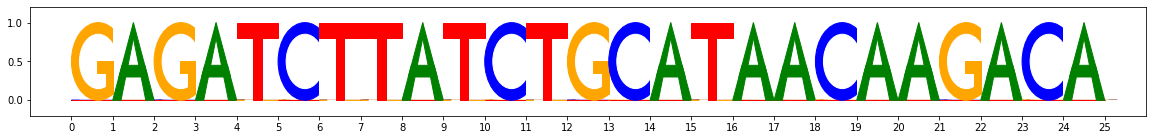

s1 s2 hyp


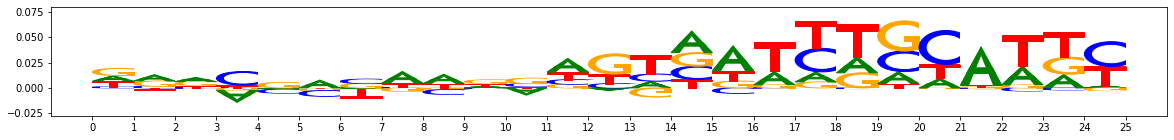

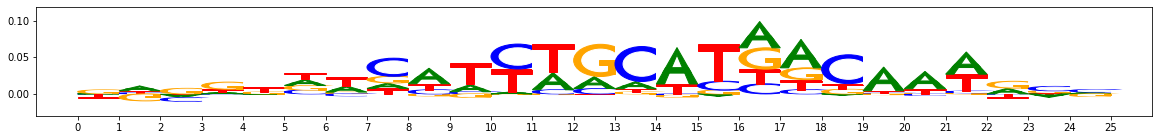

s1 s2 actual


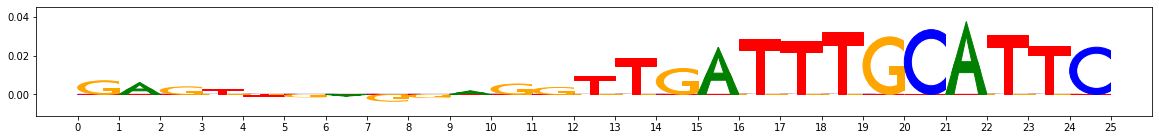

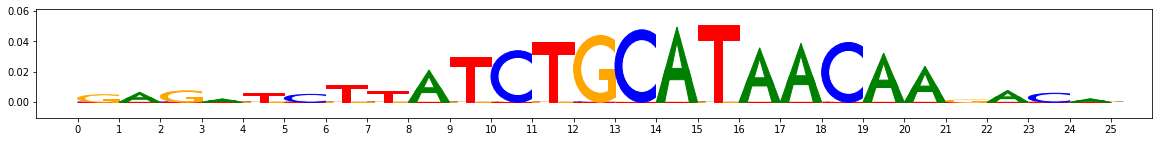

s1 s2 imputed


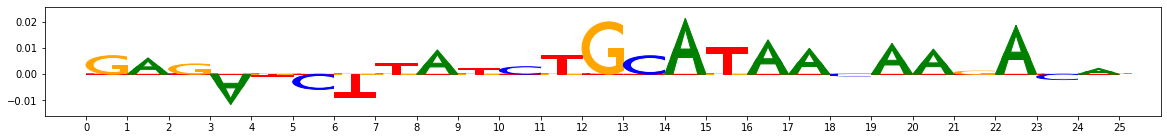

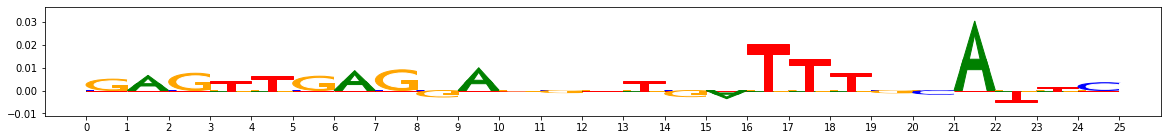

offset: 5
s1 s2 onehot


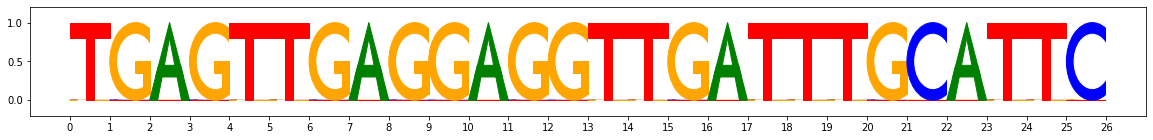

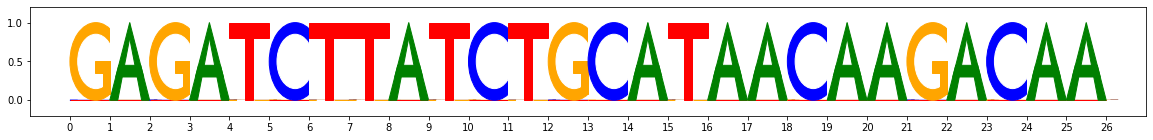

s1 s2 hyp


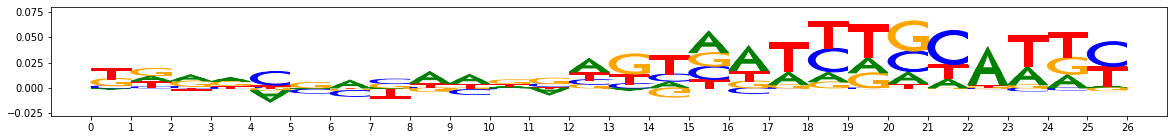

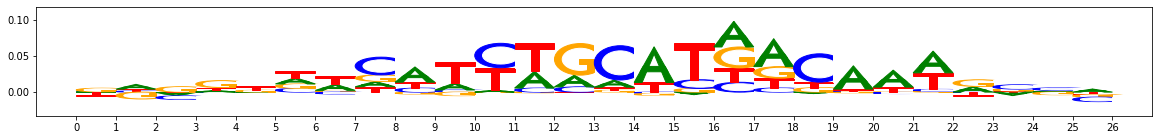

s1 s2 actual


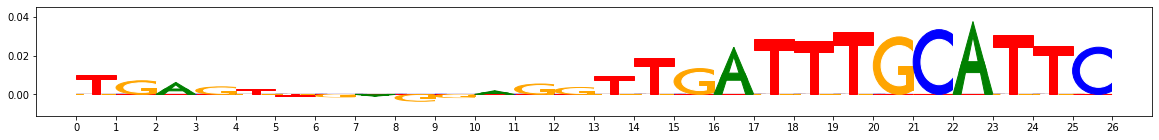

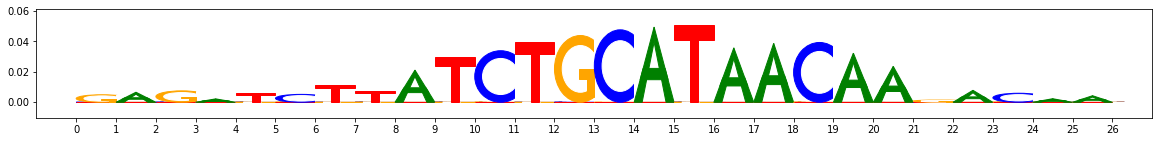

s1 s2 imputed


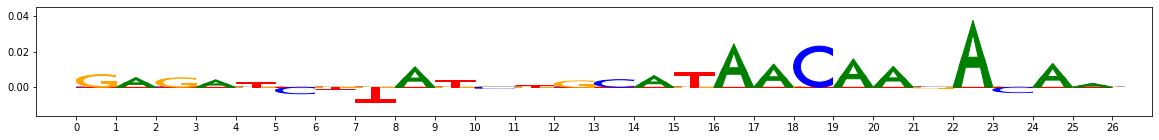

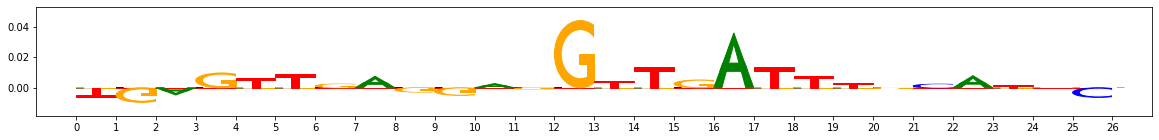

offset: 6
s1 s2 onehot


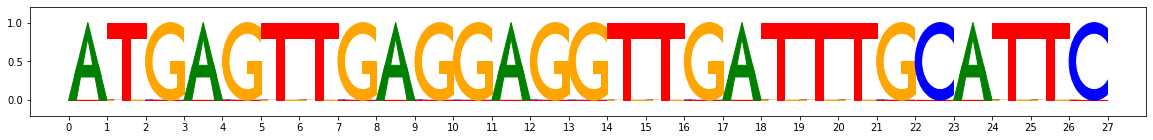

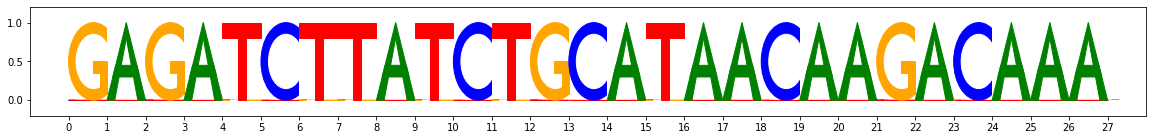

s1 s2 hyp


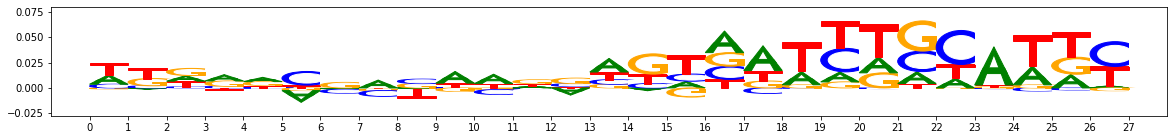

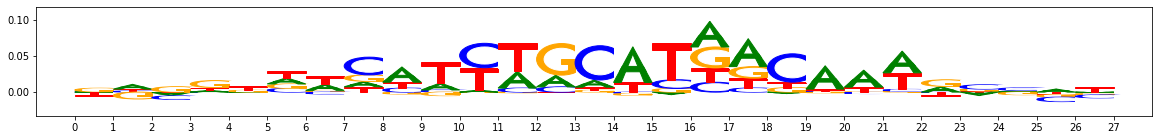

s1 s2 actual


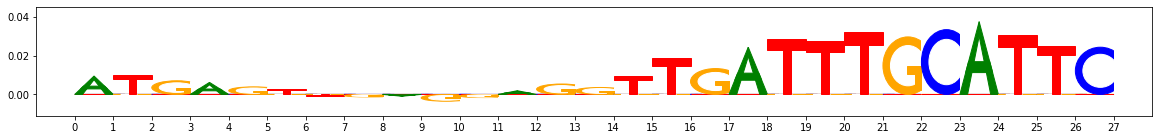

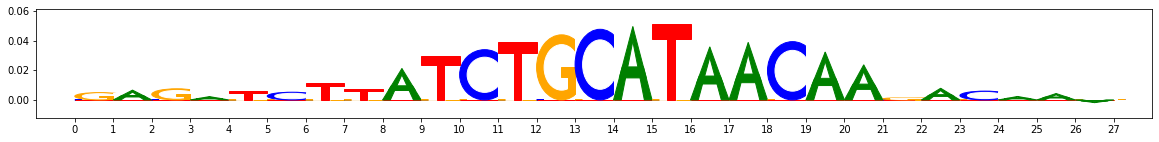

s1 s2 imputed


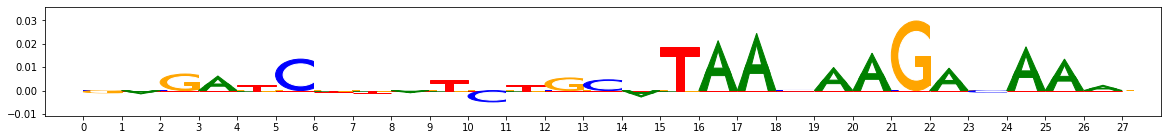

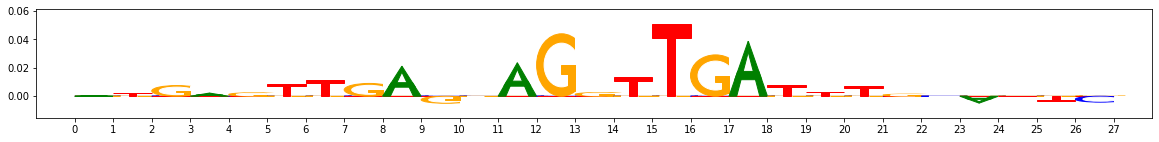

offset: 7
s1 s2 onehot


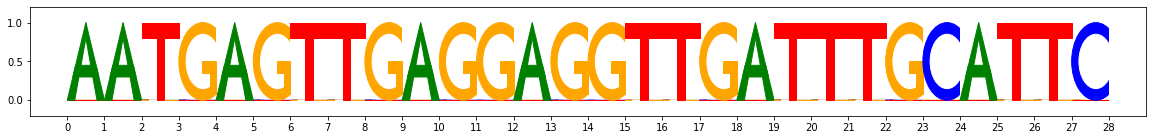

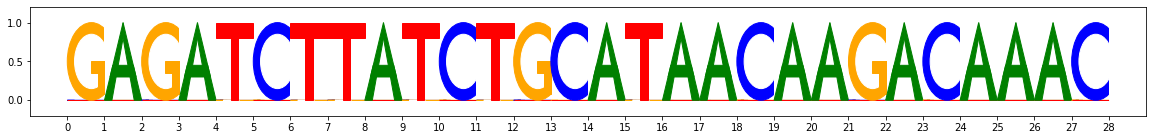

s1 s2 hyp


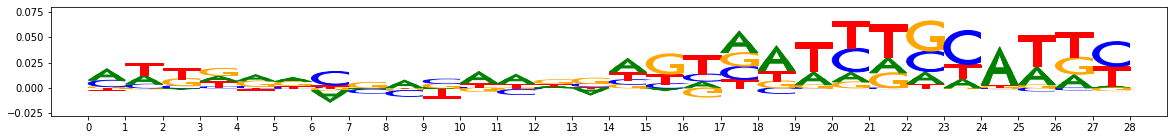

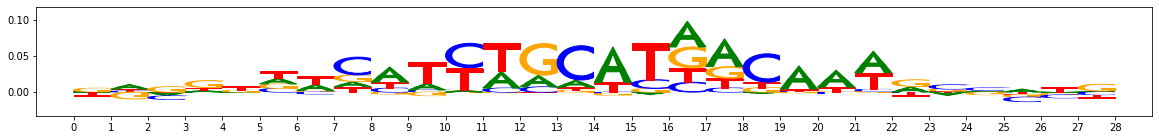

s1 s2 actual


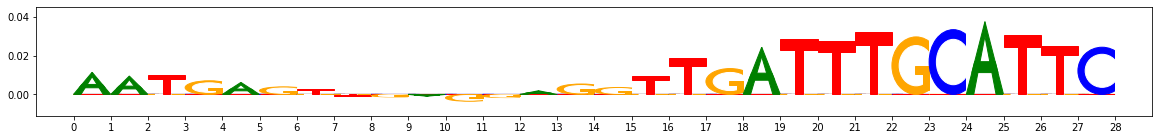

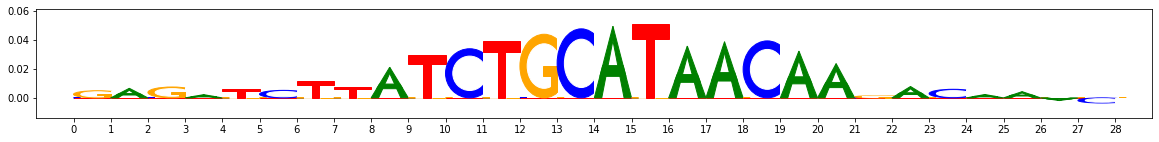

s1 s2 imputed


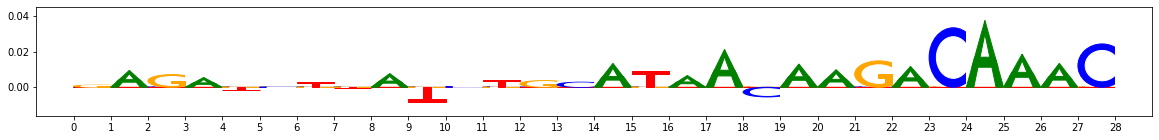

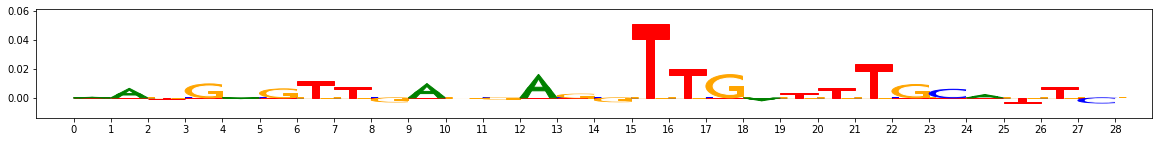

0.6816417444492913

In [273]:
compute_sim_on_pair(seqldat1, seqldat2, min_overlap_frac,
                    pair_l1norm_contin_jaccard_sim)